# Modelling by Exercise Reps

For these series of models, I wanted to look into being able to predict the exercises from a more limited amount of data. Would it be possible to find a model that would be able to accurately determine which exercises were being done from only 1 or 2 repetitions worth of measurements.

In [25]:
# Library

import pickle
import pandas as pd
import numpy as np
from collections import Counter
import os

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from keras.utils import to_categorical
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from keras.optimizers import Adam, schedules
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
import keras_tuner as kt
from tensorflow.keras.regularizers import l2
import tensorflow as tf

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


**Recurrent Neural Networks (RNN) learning and  experimentation**

A major roadblock for me during this project was figuring out how to deal with inputs of vastly different lengths. During the first models, data was omitted from some of the sets in order to equalize the number of rows and columns being used. While this wasn't a terribly difficult thing to achieve, it never feels 'right' to have to remove data that could be useful for predicting things more accurately. 

Researching the directions I was hoping to explore and discussing my ideas and concerns with mentors and associates in the industry, lead me to learn more about Recurrent Neural Networks and specifically the Long Short-Term Memory (LSTM) architecture and its use for sequential analysis.

Sources:\
https://www.ibm.com/topics/recurrent-neural-networks \
https://www.analyticsvidhya.com/blog/2021/03/introduction-to-long-short-term-memory-lstm/ \
https://machinelearningmastery.com/softmax-activation-function-with-python/

## One Rep

#### Processing

In [4]:
# loading pickle data file where rotational matrices are already converted to euler angles

def load_dataframes(file_path):
    with open(file_path, 'rb') as file:
        loaded_data = pickle.load(file)
    return loaded_data

In [5]:
exercises_euler = load_dataframes('..\data\pickle\data_with_euler.pkl')

In [6]:
exercises_euler[7][0]

,exercise,num_reps,watch_location,crown_orientation,ref_xy_rotation,rel_baseline_speed,max_rel_speed_change,trim_start_frac,trim_end_frac,kinematic_noise_factor,...,seconds_per_rep,num_random_frames,rep_count_from_intermediate,rep_count_from_start,time,rep_num,avg_rep_time,euler_x,euler_y,euler_z
0,PUSHUP,13,LEFT,LEFT,0.371318,1.378867,0.135134,0.02399,0.099473,1.177065,...,1.0,100,0.482143,0.000000,0.00,1,1.334615,-1.828495,0.719966,-1.802005
1,PUSHUP,13,LEFT,LEFT,0.371318,1.378867,0.135134,0.02399,0.099473,1.177065,...,1.0,100,0.523029,0.040886,0.05,1,1.334615,-1.827391,0.764163,-1.798494
2,PUSHUP,13,LEFT,LEFT,0.371318,1.378867,0.135134,0.02399,0.099473,1.177065,...,1.0,100,0.563958,0.081815,0.10,1,1.334615,-1.777242,0.805475,-1.752962
3,PUSHUP,13,LEFT,LEFT,0.371318,1.378867,0.135134,0.02399,0.099473,1.177065,...,1.0,100,0.604928,0.122786,0.15,1,1.334615,-1.664050,0.839073,-1.659022
4,PUSHUP,13,LEFT,LEFT,0.371318,1.378867,0.135134,0.02399,0.099473,1.177065,...,1.0,100,0.645941,0.163798,0.20,1,1.334615,-1.523027,0.852995,-1.544831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,PUSHUP,13,LEFT,LEFT,0.371318,1.378867,0.135134,0.02399,0.099473,1.177065,...,1.0,100,13.322958,12.840815,17.15,13,1.334615,-1.544517,0.938857,-1.554208
344,PUSHUP,13,LEFT,LEFT,0.371318,1.378867,0.135134,0.02399,0.099473,1.177065,...,1.0,100,13.357053,12.874910,17.20,13,1.334615,-1.681956,0.909200,-1.666234
345,PUSHUP,13,LEFT,LEFT,0.371318,1.378867,0.135134,0.02399,0.099473,1.177065,...,1.0,100,13.391163,12.909020,17.25,13,1.334615,-1.795023,0.877236,-1.760592
346,PUSHUP,13,LEFT,LEFT,0.371318,1.378867,0.135134,0.02399,0.099473,1.177065,...,1.0,100,13.425291,12.943148,17.30,13,1.334615,-1.864479,0.853114,-1.822091


In [7]:
# Separating lists of data frames by exercise

armraise_e = exercises_euler[0]
bicep_curl_e = exercises_euler[1]
bird_dog_e = exercises_euler[2]
burpee_e = exercises_euler[3]
crunches_e = exercises_euler[4]
hammer_curl_e = exercises_euler[5]
overhead_press_e = exercises_euler[6]
pushup_e = exercises_euler[7]
tricep_left_e = exercises_euler[8]
tricep_right_e = exercises_euler[9]
vup_e = exercises_euler[10]

In [8]:
# Dropping unnecessary columns

data_sets = [armraise_e, bicep_curl_e, bird_dog_e, burpee_e, crunches_e, hammer_curl_e, overhead_press_e, pushup_e, tricep_left_e, tricep_right_e, vup_e]

columns_to_drop = ['num_reps', 'trim_start_frac', 'trim_end_frac', 'use_random_motion', 'randomize_body_shape', 'frames_per_second', 'image_width', 'image_height', 'random_seed', 'seconds_per_rep', 'num_random_frames', 'rep_count_from_intermediate', 'rep_count_from_start']

for i, df_list in enumerate(data_sets):
    for j, df in enumerate(df_list):
        data_sets[i][j] = df.drop(columns=columns_to_drop, axis=1)

In [9]:
hammer_curl_e[0].head(1)

,exercise,watch_location,crown_orientation,ref_xy_rotation,rel_baseline_speed,max_rel_speed_change,kinematic_noise_factor,wrist_offset_deg,time,rep_num,avg_rep_time,euler_x,euler_y,euler_z
0,HAMMER_CURL-DUMBBELL,LEFT,RIGHT,3.795629,1.517165,0.025838,0.807775,-0.435791,0.0,1,2.013636,1.217235,0.364028,-1.639248


#### Encoding

In [10]:
# Encoding watch location and crown orientation

for df_list in data_sets:
    for df in df_list:
        df['watch_location'] = df['watch_location'].map({'LEFT': 0, 'RIGHT': 1})
        df['crown_orientation'] = df['crown_orientation'].map({'LEFT': 0, 'RIGHT': 1})
       

In [11]:
# Define a custom mapping of exercise names to numerical labels, encoding exercise columns

exercise_mapping = {
    'ARM_RAISE-DUMBBELL': 0,
    'BICEP_CURL-DUMBBELL': 1,
    'BIRD_DOG': 2,
    'BURPEE': 3,
    'CRUNCHES': 4,
    'HAMMER_CURL-DUMBBELL': 5,
    'OVERHEAD_PRESS-DUMBBELL': 6,
    'PUSHUP': 7,
    'TRICEP_KICKBACK-BENT_OVER+SINGLE_ARM-DUMBBELL-LEFT': 8,
    'TRICEP_KICKBACK-BENT_OVER+SINGLE_ARM-DUMBBELL-RIGHT': 9,
    'V_UP': 10
}

for df_list in data_sets:
    for df in df_list:
        
        df['exercise_encoded'] = df['exercise'].map(exercise_mapping)


In [12]:
# Drop exercise column

for i, df_list in enumerate(data_sets):
    for j, df in enumerate(df_list):
        data_sets[i][j] = df.drop(columns='exercise')

In [13]:
len(armraise_e[0])

714

In [14]:
# Separating the exercise dataframes into individual dataframes by rep num

rep_num_dfs_list = []
data_sets = [armraise_e, bicep_curl_e, bird_dog_e, burpee_e, crunches_e, hammer_curl_e, overhead_press_e, pushup_e, tricep_left_e, tricep_right_e, vup_e]

for df_list in data_sets:
    for df in df_list:
        grouped = df.groupby('rep_num')

        for rep_num, group_df in grouped:
            rep_num_dfs_list.append(group_df)


In [15]:
len(rep_num_dfs_list)

22957

### Save

In [18]:
# saving list before removing rep_num column

with open('../data/pickle/rep_num_dfs_list_no_scale.pkl', 'wb') as file:
    pickle.dump(rep_num_dfs_list, file)


### Load

In [19]:
#loading

with open('../data/pickle/rep_num_dfs_list_no_scale.pkl', 'rb') as file:
    rep_num_dfs_list = pickle.load(file)


In [14]:
# Dropping columns

for df in rep_num_dfs_list:
    df.drop('time', axis=1, inplace=True)
for df in rep_num_dfs_list:
    df.drop('avg_rep_time', axis=1, inplace=True)
for df in rep_num_dfs_list:
    df.drop('rep_num', axis=1, inplace=True)

In [16]:
rep_num_dfs_list[11].head(1)

,watch_location,crown_orientation,ref_xy_rotation,rel_baseline_speed,max_rel_speed_change,kinematic_noise_factor,wrist_offset_deg,time,rep_num,avg_rep_time,euler_x,euler_y,euler_z,exercise_encoded
656,1,0,4.818261,0.851037,0.024017,0.980721,9.201472,32.8,12,2.970833,0.110696,-1.063851,-0.155655,0


### Keras Sequential Neural Network

I hadn't previously done much work with neural networks prior to embarking on this project, so there was a big learning curve and a LOT of trial and error heading into these models. 

Sources:\
https://faroit.com/keras-docs/1.2.0/getting-started/sequential-model-guide/

In [17]:
# Preparing X and y

X = [df.drop('exercise_encoded', axis=1).values for df in rep_num_dfs_list]
y = [df['exercise_encoded'].values[0] if not df.empty else None for df in rep_num_dfs_list]
print(len(X))
print(len(y))

22957
22957


In [18]:
# Remove None values from y (if any) and convert to empty arrays

y = [val if val is not None else np.array([]) for val in y]
y = [val if isinstance(val, np.ndarray) else np.array([val]) for val in y]

# Pad each array in X to the maximum length
max_length = max(len(x) for x in X)
X_padded = pad_sequences(X, maxlen=max_length, padding='post', dtype='float32')

y_concatenated = np.concatenate(y)

In [19]:
# Split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X_padded, y_concatenated, test_size=0.2, random_state=42)

In [20]:
# One-hot encode the target variable for multi-class classification

y_train_one_hot = to_categorical(y_train, num_classes=11)
y_test_one_hot = to_categorical(y_test, num_classes=11)

In [ ]:
# Checking for class imbalance

y_counts = np.unique(y_train, return_counts=True)

for value, count in zip(y_counts[0], y_counts[1]):
    print(f"Value {value}: Count {count}")


---

## One Rep, First Attempt

Sources:\
https://keras.io/guides/training_with_built_in_methods/ \
https://machinelearningmastery.com/evaluate-skill-deep-learning-models/ \
https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/

There are many sources online (I have included one above) discussing the importance of re-running the models multiple times to obtain a 'grand mean' to truly evaluate the model's performance. I discovered some of the importance of this as I moved through this project. After changing some of my preprocessing I was forced to rerun some of my intial models in this section. It wasn't until I did that, that I realized the results of my models were not only inconsistent, but varying by huge amounts. Neural networks use randomness in their initialization which can lead to vastly different outcomes in the runs. Because of this I have started running the models mutliple times. I do not claim that 5 times is the appropriate number, but time is not on my side at this point and I will be using 5 model repetitions to show my work. I may revisit this later and try some larger numbers.

This first attempt is a very basic model to give us a starting point. I am not expecting anything fantastic.

Because the data I am using is sequential I have used an LSTM layer to approach my task.

In [82]:
# Build the LSTM model

model1 = Sequential()
model1.add(LSTM(64, input_shape=(X_train.shape[1],X_train.shape[2])))
model1.add(Dense(11, activation='softmax')) 

# Compile the model
optimizer = Adam(learning_rate=0.01)
model1.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Print model summary
model1.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 64)                19200     
                                                                 
 dense_22 (Dense)            (None, 11)                715       
                                                                 
Total params: 19915 (77.79 KB)
Trainable params: 19915 (77.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [83]:
# Training the model
history_1_Rep_1 = model1.fit(X_train, y_train_one_hot, epochs=10, batch_size=64, validation_data=(X_test, y_test_one_hot))

Epoch 1/10
287/287 [==============================] - 46s 155ms/step - loss: 2.3742 - accuracy: 0.1008 - val_loss: 2.3811 - val_accuracy: 0.0965
Epoch 2/10
287/287 [==============================] - 44s 154ms/step - loss: 2.3718 - accuracy: 0.1000 - val_loss: 2.3800 - val_accuracy: 0.1017
Epoch 3/10
287/287 [==============================] - 45s 155ms/step - loss: 2.3590 - accuracy: 0.1060 - val_loss: 2.3149 - val_accuracy: 0.1280
Epoch 4/10
287/287 [==============================] - 45s 156ms/step - loss: 2.3349 - accuracy: 0.1218 - val_loss: 2.3798 - val_accuracy: 0.0991
Epoch 5/10
287/287 [==============================] - 45s 155ms/step - loss: 2.3711 - accuracy: 0.1031 - val_loss: 2.3788 - val_accuracy: 0.1017
Epoch 6/10
287/287 [==============================] - 44s 154ms/step - loss: 2.3605 - accuracy: 0.1065 - val_loss: 2.2445 - val_accuracy: 0.1572
Epoch 7/10
287/287 [==============================] - 45s 156ms/step - loss: 2.1073 - accuracy: 0.2231 - val_loss: 2.2339 - val_ac

In [84]:
# Model Evaluation
loss, accuracy = model1.evaluate(X_test, y_test_one_hot)
print(f'Overall Accuracy: {accuracy * 100:.2f}%')

144/144 [==============================] - 9s 61ms/step - loss: 1.5187 - accuracy: 0.4251
Overall Accuracy: 42.51%


Training accuracy and validation accuracy are 36.77% and 42.51% respectively, which is much better than I was expecting. As you can see in the graph below, the model is a little slow to start and should probably have been run for a larger number of epochs, but from a very basic model this is not surprising. We will try some adjustments to the hyperparameters to see what improvements we can make. Below are some visual evaluations to see how things are progressing.

This was my initial model that I ran without repetitions. I have included below the model that was repeated 5 times. 

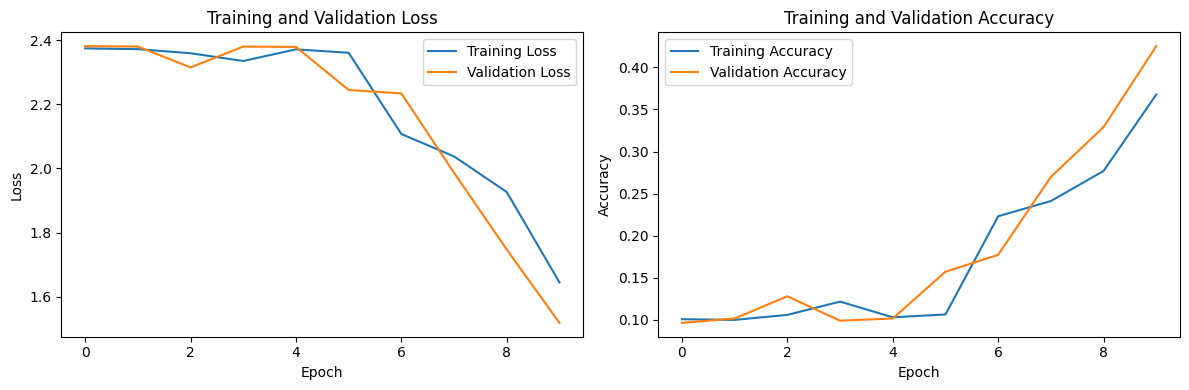

In [85]:
plt.figure(figsize=(12, 4))

# Plotting Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(history_1_Rep_1.history['loss'], label='Training Loss')
plt.plot(history_1_Rep_1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_1_Rep_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_1_Rep_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout() 
plt.show()

144/144 [==============================] - 9s 62ms/step


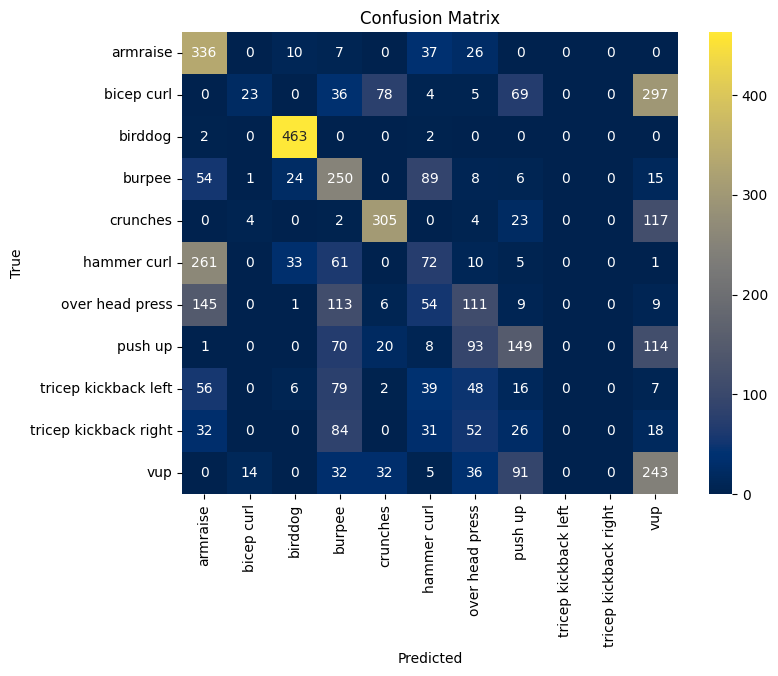

In [86]:
# Create confusion matrix

y_pred = model1.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_one_hot, axis=1)

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
class_labels = ['armraise', 'bicep curl', 'birddog', 'burpee', 'crunches', 'hammer curl', 'over head press', 'push up', 'tricep kickback left', 'tricep kickback right', 'vup']
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='cividis', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


#### Repetition runs of model 1

Epoch 1/10
287/287 [==============================] - 46s 157ms/step - loss: 2.3747 - accuracy: 0.0987 - val_loss: 2.3803 - val_accuracy: 0.0976
Epoch 2/10
287/287 [==============================] - 44s 153ms/step - loss: 2.3716 - accuracy: 0.0975 - val_loss: 2.3790 - val_accuracy: 0.0991
Epoch 3/10
287/287 [==============================] - 44s 153ms/step - loss: 2.3709 - accuracy: 0.1025 - val_loss: 2.3782 - val_accuracy: 0.0986
Epoch 4/10
287/287 [==============================] - 43s 151ms/step - loss: 2.3708 - accuracy: 0.1005 - val_loss: 2.3782 - val_accuracy: 0.0991
Epoch 5/10
287/287 [==============================] - 43s 150ms/step - loss: 2.3705 - accuracy: 0.1005 - val_loss: 2.3786 - val_accuracy: 0.0978
Epoch 6/10
287/287 [==============================] - 43s 150ms/step - loss: 2.3771 - accuracy: 0.1014 - val_loss: 2.3783 - val_accuracy: 0.0965
Epoch 7/10
287/287 [==============================] - 43s 152ms/step - loss: 2.3706 - accuracy: 0.1042 - val_loss: 2.3779 - val_ac

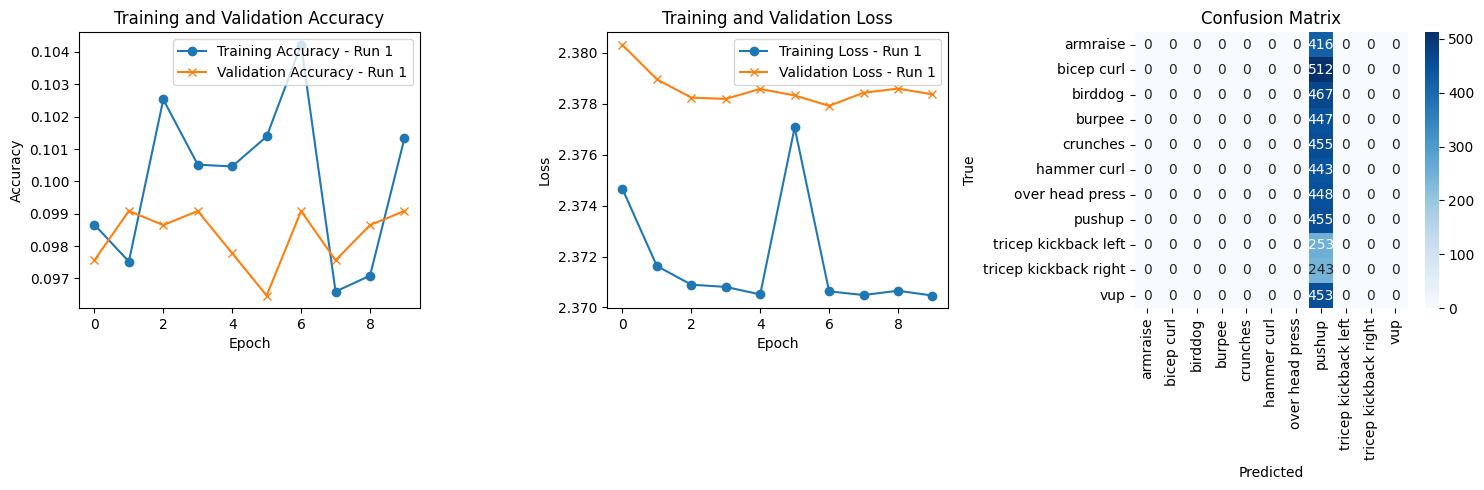

Epoch 1/10
287/287 [==============================] - 47s 158ms/step - loss: 2.3737 - accuracy: 0.0968 - val_loss: 2.3797 - val_accuracy: 0.0906
Epoch 2/10
287/287 [==============================] - 46s 159ms/step - loss: 2.3713 - accuracy: 0.1004 - val_loss: 2.3790 - val_accuracy: 0.0991
Epoch 3/10
287/287 [==============================] - 45s 156ms/step - loss: 2.3712 - accuracy: 0.0974 - val_loss: 2.3783 - val_accuracy: 0.0906
Epoch 4/10
287/287 [==============================] - 46s 160ms/step - loss: 2.3708 - accuracy: 0.0990 - val_loss: 2.3783 - val_accuracy: 0.0976
Epoch 5/10
287/287 [==============================] - 46s 160ms/step - loss: 2.3706 - accuracy: 0.0985 - val_loss: 2.3789 - val_accuracy: 0.0906
Epoch 6/10
287/287 [==============================] - 46s 160ms/step - loss: 2.3704 - accuracy: 0.0981 - val_loss: 2.3775 - val_accuracy: 0.0993
Epoch 7/10
287/287 [==============================] - 46s 160ms/step - loss: 2.3691 - accuracy: 0.1000 - val_loss: 2.3772 - val_ac

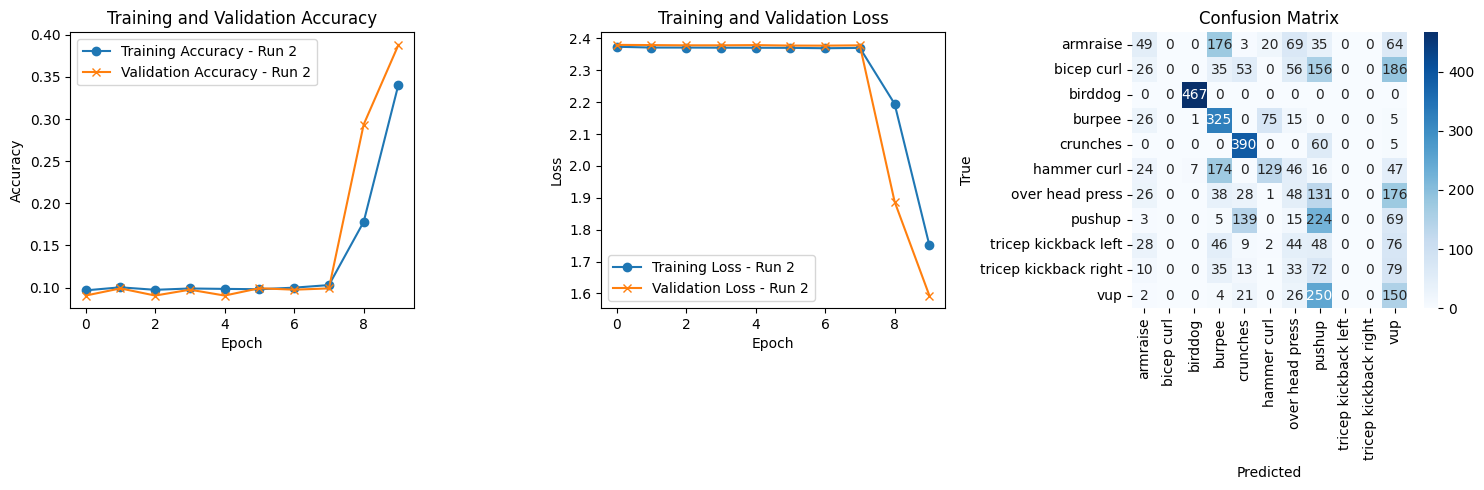

Epoch 1/10
287/287 [==============================] - 48s 161ms/step - loss: 2.3740 - accuracy: 0.1024 - val_loss: 2.3775 - val_accuracy: 0.0965
Epoch 2/10
287/287 [==============================] - 46s 160ms/step - loss: 2.3714 - accuracy: 0.0988 - val_loss: 2.3795 - val_accuracy: 0.0986
Epoch 3/10
287/287 [==============================] - 46s 162ms/step - loss: 2.3713 - accuracy: 0.0969 - val_loss: 2.3786 - val_accuracy: 0.0991
Epoch 4/10
287/287 [==============================] - 46s 162ms/step - loss: 2.3705 - accuracy: 0.1004 - val_loss: 2.3771 - val_accuracy: 0.0991
Epoch 5/10
287/287 [==============================] - 46s 161ms/step - loss: 2.3709 - accuracy: 0.0964 - val_loss: 2.3800 - val_accuracy: 0.0906
Epoch 6/10
287/287 [==============================] - 46s 161ms/step - loss: 2.3705 - accuracy: 0.1035 - val_loss: 2.3794 - val_accuracy: 0.0986
Epoch 7/10
287/287 [==============================] - 46s 161ms/step - loss: 2.3508 - accuracy: 0.1121 - val_loss: 2.2888 - val_ac

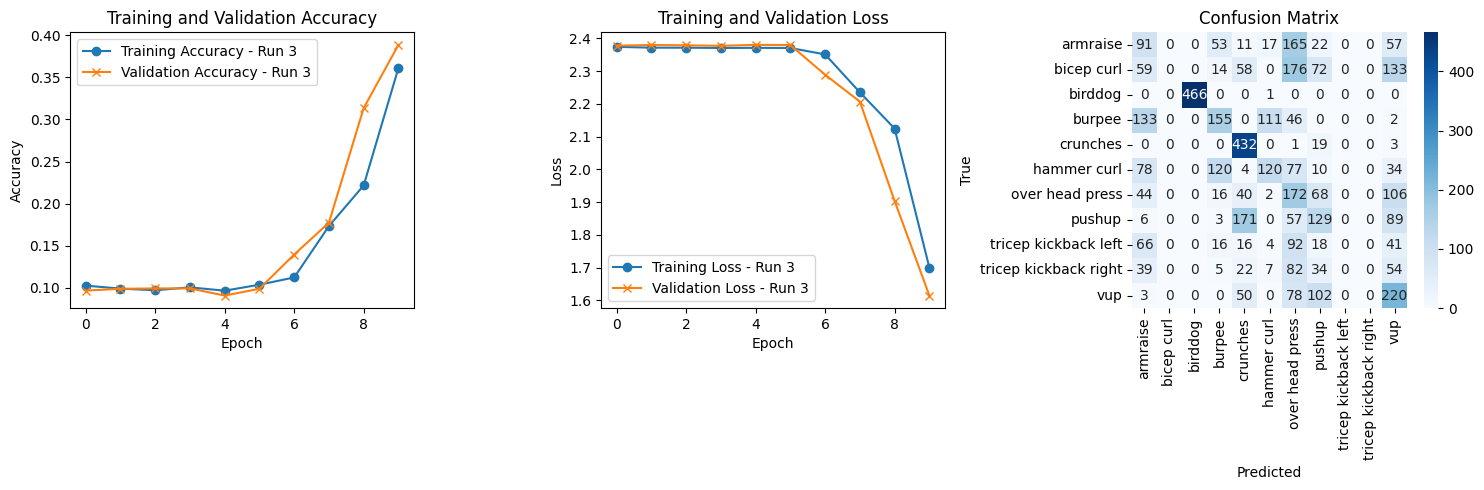

Epoch 1/10
287/287 [==============================] - 48s 163ms/step - loss: 2.3740 - accuracy: 0.1018 - val_loss: 2.3793 - val_accuracy: 0.0906
Epoch 2/10
287/287 [==============================] - 47s 163ms/step - loss: 2.3714 - accuracy: 0.0978 - val_loss: 2.3775 - val_accuracy: 0.0986
Epoch 3/10
287/287 [==============================] - 46s 162ms/step - loss: 2.3712 - accuracy: 0.0978 - val_loss: 2.3790 - val_accuracy: 0.0906
Epoch 4/10
287/287 [==============================] - 46s 161ms/step - loss: 2.3705 - accuracy: 0.1017 - val_loss: 2.3809 - val_accuracy: 0.0976
Epoch 5/10
287/287 [==============================] - 47s 163ms/step - loss: 2.3707 - accuracy: 0.0995 - val_loss: 2.3779 - val_accuracy: 0.0991
Epoch 6/10
287/287 [==============================] - 45s 155ms/step - loss: 2.3705 - accuracy: 0.0976 - val_loss: 2.3780 - val_accuracy: 0.0973
Epoch 7/10
287/287 [==============================] - 46s 161ms/step - loss: 2.3705 - accuracy: 0.0988 - val_loss: 2.3805 - val_ac

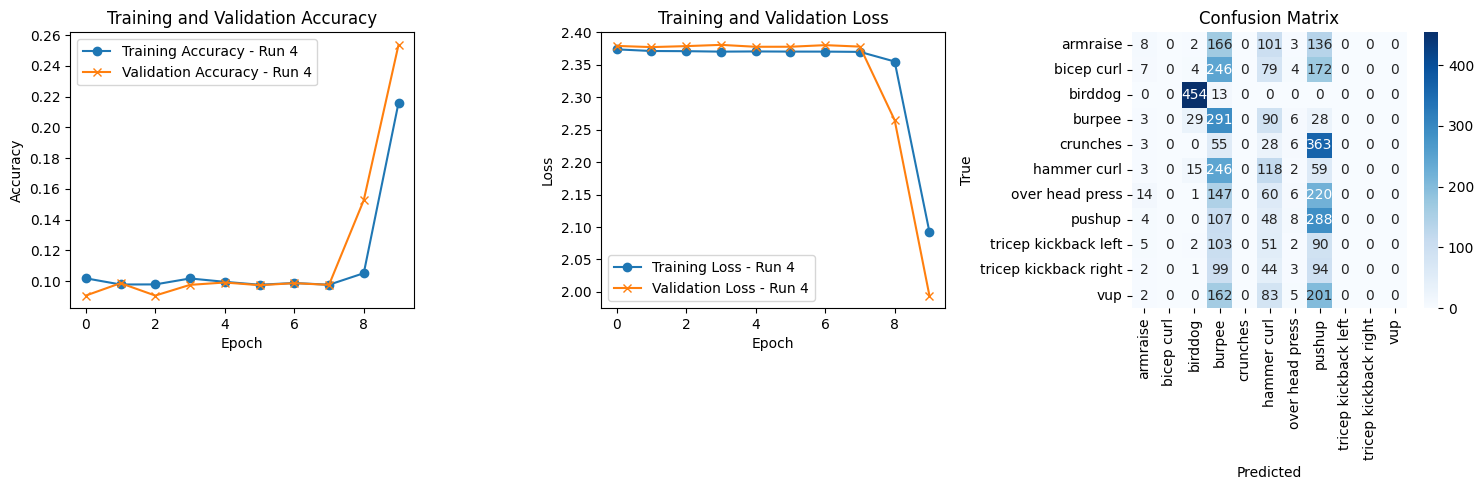

Epoch 1/10
287/287 [==============================] - 48s 162ms/step - loss: 2.3744 - accuracy: 0.1012 - val_loss: 2.3787 - val_accuracy: 0.0991
Epoch 2/10
287/287 [==============================] - 45s 157ms/step - loss: 2.3717 - accuracy: 0.0980 - val_loss: 2.3789 - val_accuracy: 0.0976
Epoch 3/10
287/287 [==============================] - 45s 158ms/step - loss: 2.3711 - accuracy: 0.0992 - val_loss: 2.3784 - val_accuracy: 0.0965
Epoch 4/10
287/287 [==============================] - 45s 157ms/step - loss: 2.3708 - accuracy: 0.0963 - val_loss: 2.3808 - val_accuracy: 0.0991
Epoch 5/10
287/287 [==============================] - 46s 160ms/step - loss: 2.3705 - accuracy: 0.1004 - val_loss: 2.3787 - val_accuracy: 0.0976
Epoch 6/10
287/287 [==============================] - 44s 153ms/step - loss: 2.3705 - accuracy: 0.0992 - val_loss: 2.3796 - val_accuracy: 0.0965
Epoch 7/10
287/287 [==============================] - 46s 160ms/step - loss: 2.3704 - accuracy: 0.0982 - val_loss: 2.3788 - val_ac

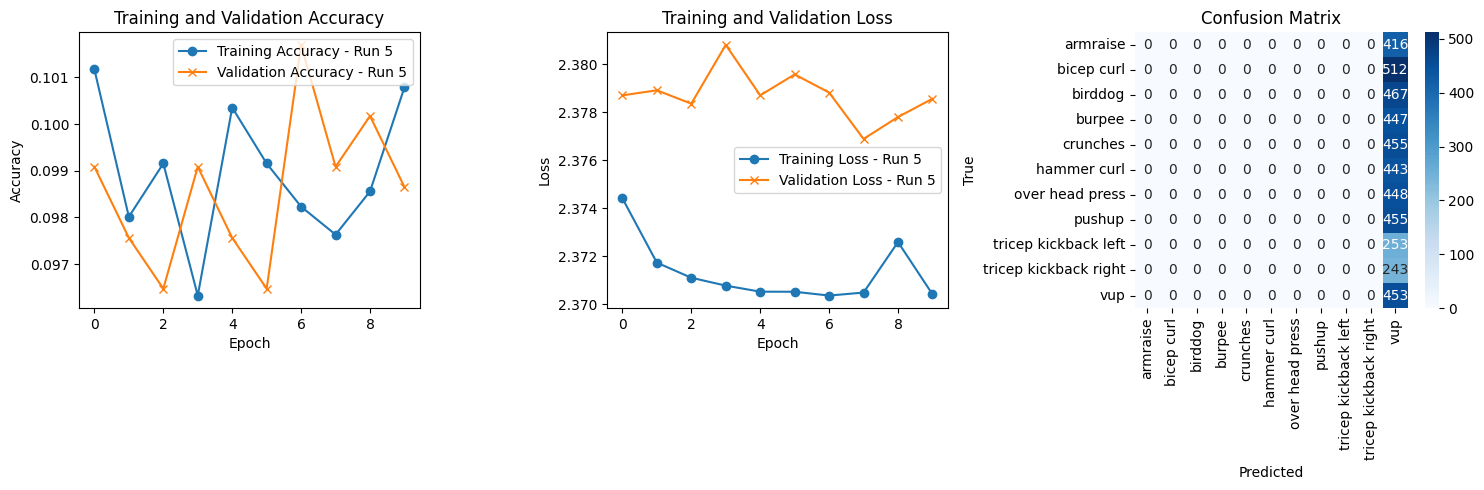

In [104]:
# Define the number of runs
num_runs = 5
all_history_1_Rep_1 = []

# Configure ModelCheckpoint callback to save weights
weights_dir = '../models/model1_weights'
os.makedirs(weights_dir, exist_ok=True)
checkpoint_filepath = os.path.join(weights_dir, 'weights_run_{epoch:02d}.h5')

# Train the model and store the history for each run
for run in range(num_runs):
    # Create and compile the model for each run
    model1 = Sequential()
    model1.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
    model1.add(Dense(11, activation='softmax'))
    optimizer = Adam(learning_rate=0.0015)
    model1.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # ModelCheckpoint callback with a dynamic file path
    model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath.replace('{run}', str(run)), save_weights_only=True, save_best_only=False)

    history = model1.fit(X_train, y_train_one_hot, epochs=10, batch_size=64, validation_data=(X_test, y_test_one_hot), callbacks=[model_checkpoint_callback])
    all_history_1_Rep_1.append(history)

    plt.figure(figsize=(15, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label=f'Training Accuracy - Run {run + 1}', marker='o')
    plt.plot(history.history['val_accuracy'], label=f'Validation Accuracy - Run {run + 1}', marker='x')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'], label=f'Training Loss - Run {run + 1}', marker='o')
    plt.plot(history.history['val_loss'], label=f'Validation Loss - Run {run + 1}', marker='x')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot confusion matrix
    plt.subplot(1, 3, 3)

    # Obtain predictions and calculate the confusion matrix
    y_pred = model1.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test_one_hot, axis=1)
    cm = confusion_matrix(y_true, y_pred_classes)

    class_labels = ['armraise', 'bicep curl', 'birddog', 'burpee', 'crunches', 'hammer curl', 'over head press', 'pushup', 'tricep kickback left', 'tricep kickback right', 'vup']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.tight_layout()
    plt.show()

# Save the final model weights
final_weights_filepath = os.path.join(weights_dir, 'final_weights.h5')
model1.save_weights(final_weights_filepath)


In [105]:
# Calculate the grand mean of each metric
grand_mean_accuracy = sum([run.history['accuracy'][-1] for run in all_history_1_Rep_1]) / num_runs
grand_mean_loss = sum([run.history['loss'][-1] for run in all_history_1_Rep_1]) / num_runs

print(f"Grand Mean Accuracy: {grand_mean_accuracy}")
print(f"Grand Mean Loss: {grand_mean_loss}")


Grand Mean Accuracy: 0.2240348532795906
Grand Mean Loss: 2.056968569755554


Well that's not very good. We can see from these plots that this model is not fitting well to the data. This is not surprising being a very basic model.  We will make some adjustments and see how we can improve on this. These model runs are also showing how much the model can fluctuate by rerunning them. The accuracy on a couple of the runs were almost 39% while others were closer 9%. It is also important to note that the model is reinitialized at the start of every run. Without doing this, the model will start training from where it left off in the previous run.

---

## One Rep, Second Attempt

For the next model, we will try increasing the LSTM units and adding another dense layer in order to capture the more complex patterning in the dataset, as well as adding some dropout layers to help avoid overfitting. We will also run the model for additional epochs.

Epoch 1/20
287/287 [==============================] - 145s 498ms/step - loss: 2.3759 - accuracy: 0.1005 - val_loss: 2.3783 - val_accuracy: 0.0976
Epoch 2/20
287/287 [==============================] - 141s 492ms/step - loss: 2.3732 - accuracy: 0.0994 - val_loss: 2.3811 - val_accuracy: 0.0986
Epoch 3/20
287/287 [==============================] - 141s 491ms/step - loss: 2.3729 - accuracy: 0.1011 - val_loss: 2.3807 - val_accuracy: 0.0976
Epoch 4/20
287/287 [==============================] - 141s 491ms/step - loss: 2.3713 - accuracy: 0.1044 - val_loss: 2.3788 - val_accuracy: 0.0976
Epoch 5/20
287/287 [==============================] - 141s 490ms/step - loss: 2.3739 - accuracy: 0.0988 - val_loss: 2.3794 - val_accuracy: 0.0965
Epoch 6/20
287/287 [==============================] - 141s 491ms/step - loss: 2.3532 - accuracy: 0.1275 - val_loss: 2.1127 - val_accuracy: 0.2219
Epoch 7/20
287/287 [==============================] - 140s 488ms/step - loss: 2.0630 - accuracy: 0.2327 - val_loss: 1.8408 -

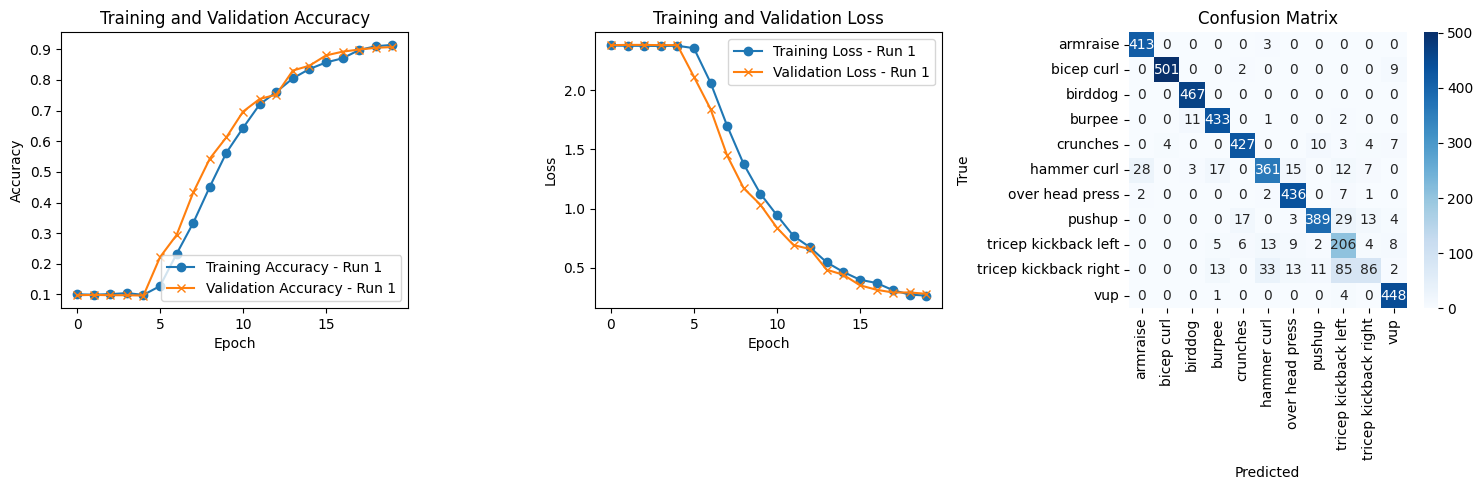

Epoch 1/20
287/287 [==============================] - 140s 481ms/step - loss: 2.3754 - accuracy: 0.0992 - val_loss: 2.3817 - val_accuracy: 0.0906
Epoch 2/20
287/287 [==============================] - 144s 501ms/step - loss: 2.3858 - accuracy: 0.0981 - val_loss: 2.4563 - val_accuracy: 0.0906
Epoch 3/20
287/287 [==============================] - 146s 510ms/step - loss: 2.3835 - accuracy: 0.1018 - val_loss: 2.3818 - val_accuracy: 0.0991
Epoch 4/20
287/287 [==============================] - 144s 500ms/step - loss: 2.3739 - accuracy: 0.1010 - val_loss: 2.3876 - val_accuracy: 0.0976
Epoch 5/20
287/287 [==============================] - 144s 503ms/step - loss: 2.3741 - accuracy: 0.0968 - val_loss: 2.3794 - val_accuracy: 0.0991
Epoch 6/20
287/287 [==============================] - 144s 500ms/step - loss: 2.3740 - accuracy: 0.1007 - val_loss: 2.3773 - val_accuracy: 0.1115
Epoch 7/20
287/287 [==============================] - 150s 522ms/step - loss: 2.3726 - accuracy: 0.1014 - val_loss: 2.3798 -

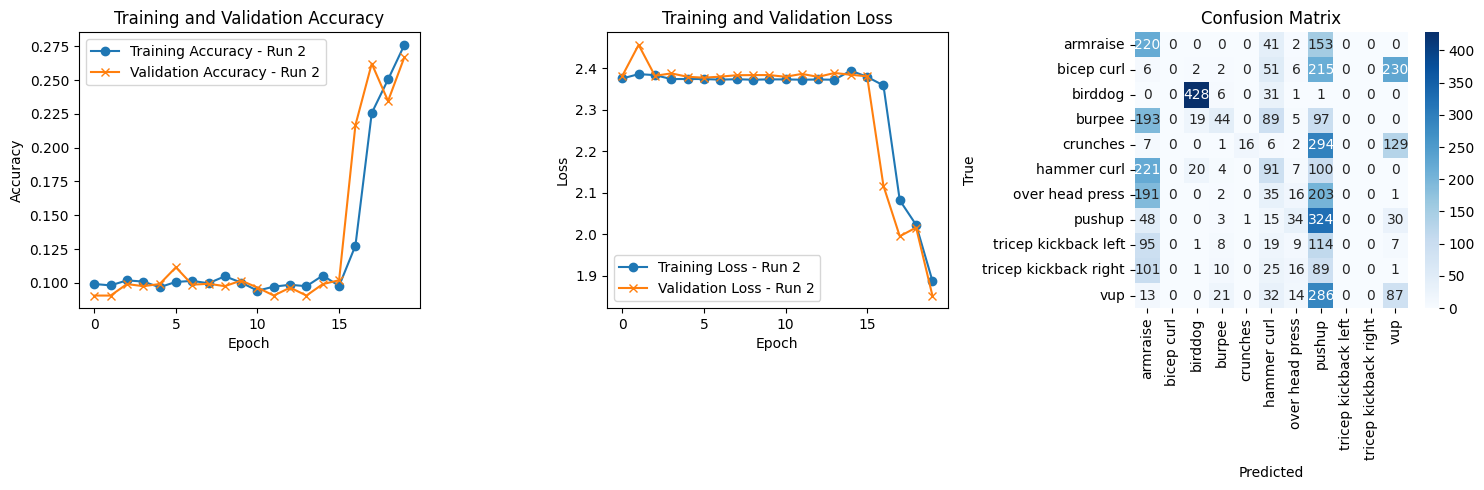

Epoch 1/20
287/287 [==============================] - 137s 472ms/step - loss: 2.4206 - accuracy: 0.1020 - val_loss: 2.3991 - val_accuracy: 0.0980
Epoch 2/20
287/287 [==============================] - 137s 477ms/step - loss: 2.3862 - accuracy: 0.0992 - val_loss: 2.3885 - val_accuracy: 0.0993
Epoch 3/20
287/287 [==============================] - 138s 480ms/step - loss: 2.3775 - accuracy: 0.0960 - val_loss: 2.3811 - val_accuracy: 0.0912
Epoch 4/20
287/287 [==============================] - 140s 488ms/step - loss: 2.3762 - accuracy: 0.1051 - val_loss: 2.3774 - val_accuracy: 0.1115
Epoch 5/20
287/287 [==============================] - 153s 534ms/step - loss: 2.3756 - accuracy: 0.0988 - val_loss: 2.3784 - val_accuracy: 0.0943
Epoch 6/20
287/287 [==============================] - 154s 536ms/step - loss: 2.3740 - accuracy: 0.1056 - val_loss: 2.3814 - val_accuracy: 0.0943
Epoch 7/20
287/287 [==============================] - 152s 530ms/step - loss: 2.3752 - accuracy: 0.0994 - val_loss: 2.3785 -

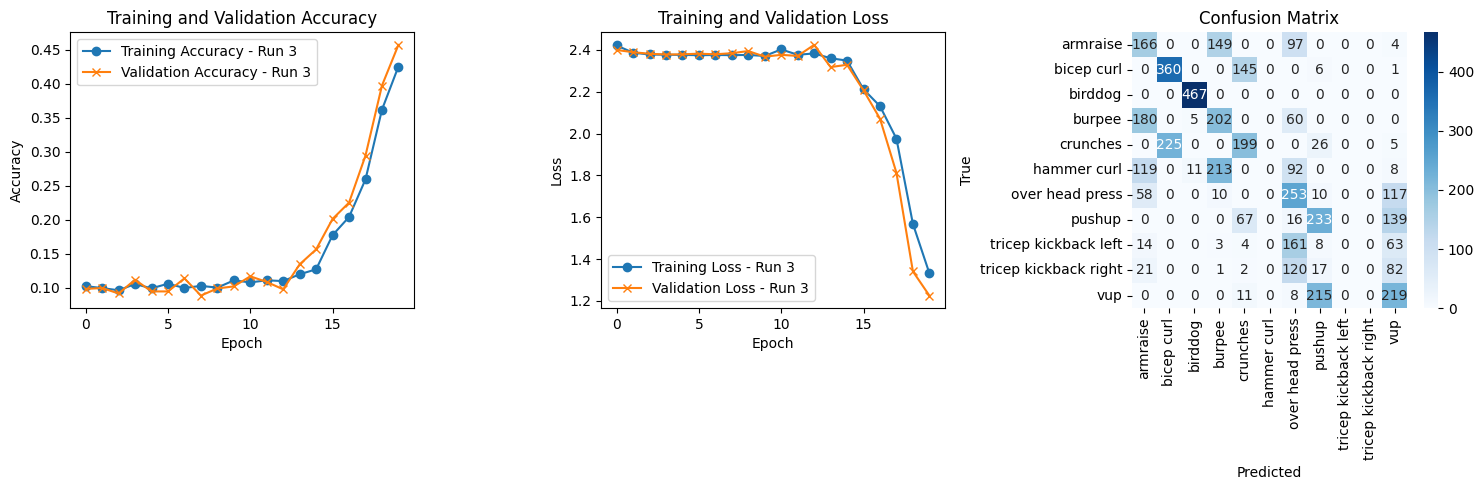

Epoch 1/20
287/287 [==============================] - 178s 613ms/step - loss: 2.3747 - accuracy: 0.1025 - val_loss: 2.3816 - val_accuracy: 0.1017
Epoch 2/20
287/287 [==============================] - 178s 620ms/step - loss: 2.4196 - accuracy: 0.1007 - val_loss: 2.3940 - val_accuracy: 0.1063
Epoch 3/20
287/287 [==============================] - 174s 605ms/step - loss: 2.3655 - accuracy: 0.1167 - val_loss: 2.2925 - val_accuracy: 0.1542
Epoch 4/20
287/287 [==============================] - 172s 598ms/step - loss: 2.2911 - accuracy: 0.1497 - val_loss: 2.2871 - val_accuracy: 0.1433
Epoch 5/20
287/287 [==============================] - 166s 578ms/step - loss: 2.3489 - accuracy: 0.1229 - val_loss: 2.3350 - val_accuracy: 0.1230
Epoch 6/20
287/287 [==============================] - 163s 566ms/step - loss: 2.2214 - accuracy: 0.1744 - val_loss: 2.9687 - val_accuracy: 0.1361
Epoch 7/20
287/287 [==============================] - 172s 598ms/step - loss: 2.2981 - accuracy: 0.1532 - val_loss: 2.1594 -

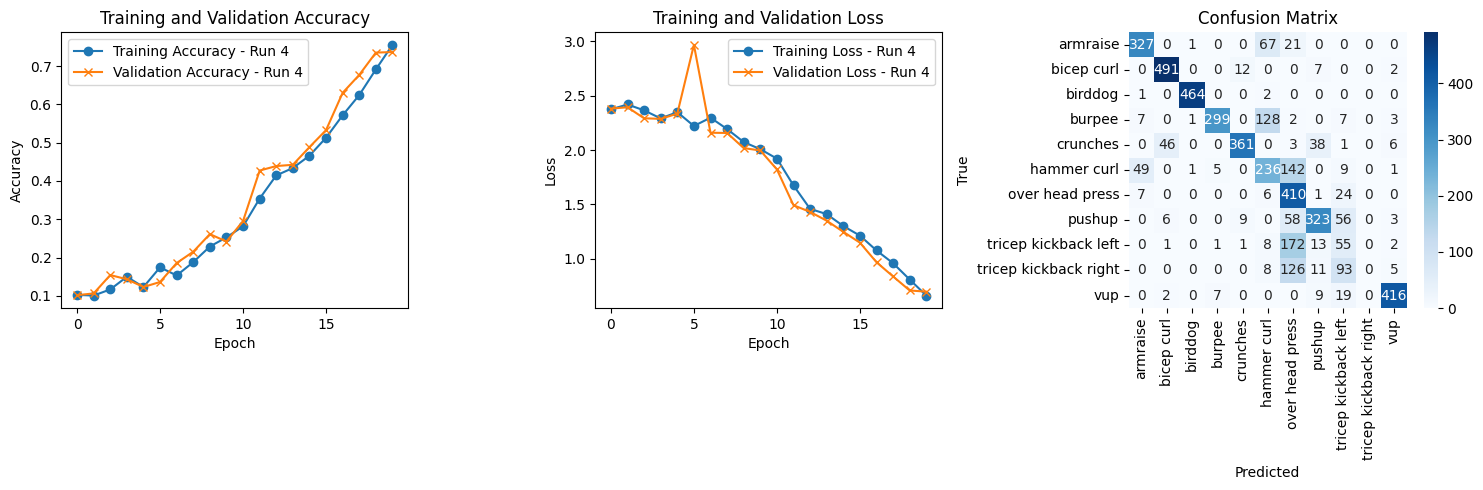

Epoch 1/20
287/287 [==============================] - 181s 624ms/step - loss: 2.3751 - accuracy: 0.1014 - val_loss: 2.3780 - val_accuracy: 0.0973
Epoch 2/20
287/287 [==============================] - 177s 617ms/step - loss: 2.3729 - accuracy: 0.0980 - val_loss: 2.3926 - val_accuracy: 0.0906
Epoch 3/20
287/287 [==============================] - 178s 620ms/step - loss: 2.3724 - accuracy: 0.0996 - val_loss: 2.3790 - val_accuracy: 0.0965
Epoch 4/20
287/287 [==============================] - 178s 621ms/step - loss: 2.4090 - accuracy: 0.1027 - val_loss: 2.3806 - val_accuracy: 0.0991
Epoch 5/20
287/287 [==============================] - 179s 622ms/step - loss: 2.3744 - accuracy: 0.1027 - val_loss: 2.3793 - val_accuracy: 0.0965
Epoch 6/20
287/287 [==============================] - 179s 624ms/step - loss: 2.3614 - accuracy: 0.1155 - val_loss: 2.3445 - val_accuracy: 0.1017
Epoch 7/20
287/287 [==============================] - 177s 617ms/step - loss: 2.3375 - accuracy: 0.1170 - val_loss: 2.3224 -

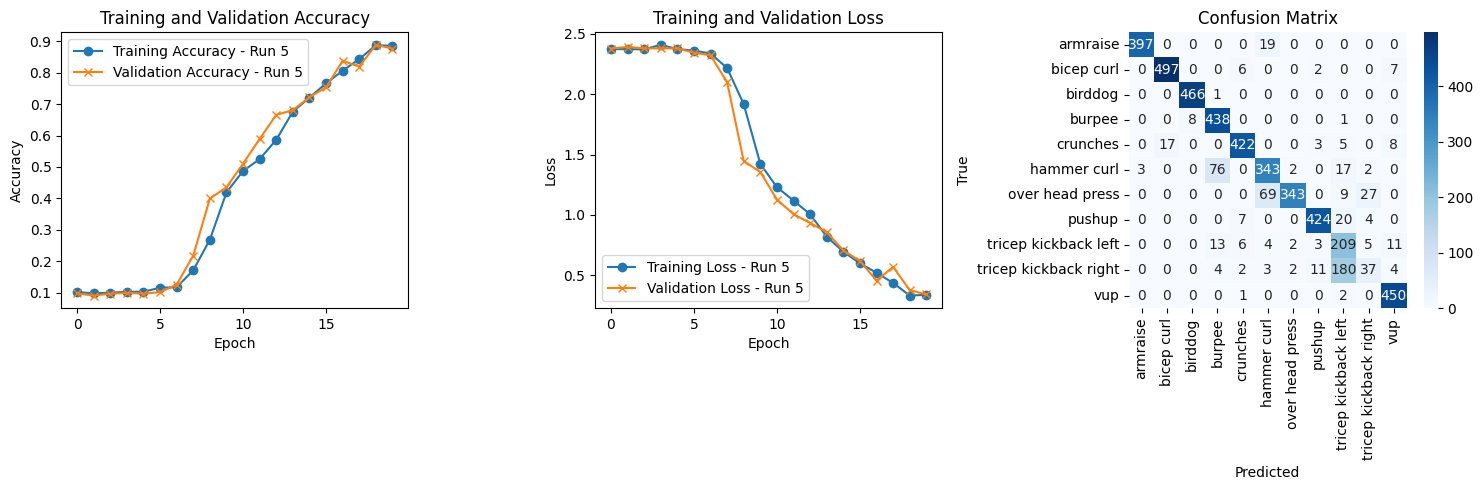

In [108]:
num_runs = 5
all_history_1_Rep_2 = []

# Configure ModelCheckpoint callback to save weights
weights_dir = '../models/model1_2_weights'
os.makedirs(weights_dir, exist_ok=True)
checkpoint_filepath = os.path.join(weights_dir, 'weights_run_{epoch:02d}.h5')

for run in range(num_runs):
    model1_2 = Sequential()
    model1_2.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
    model1_2.add(Dropout(0.1))
    model1_2.add(Dense(64))
    model1_2.add(Dropout(0.1))
    model1_2.add(Dense(11, activation='softmax')) 
    
    optimizer = Adam(learning_rate=0.0055)
    model1_2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # ModelCheckpoint callback with a dynamic file path
    model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath.replace('{run}', str(run)), save_weights_only=True, save_best_only=False)

    history = model1_2.fit(X_train, y_train_one_hot, epochs=20, batch_size=64, validation_data=(X_test, y_test_one_hot))
    all_history_1_Rep_2.append(history)

    plt.figure(figsize=(15, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label=f'Training Accuracy - Run {run + 1}', marker='o')
    plt.plot(history.history['val_accuracy'], label=f'Validation Accuracy - Run {run + 1}', marker='x')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'], label=f'Training Loss - Run {run + 1}', marker='o')
    plt.plot(history.history['val_loss'], label=f'Validation Loss - Run {run + 1}', marker='x')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot confusion matrix
    plt.subplot(1, 3, 3)

    # Obtain predictions and calculate the confusion matrix
    y_pred = model1_2.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test_one_hot, axis=1)
    cm = confusion_matrix(y_true, y_pred_classes)

    class_labels = ['armraise', 'bicep curl', 'birddog', 'burpee', 'crunches', 'hammer curl', 'over head press', 'pushup', 'tricep kickback left', 'tricep kickback right', 'vup']
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.tight_layout()
    plt.show()

# Save the final model weights
final_weights_filepath = os.path.join(weights_dir, 'final_weights.h5')
model1_2.save_weights(final_weights_filepath)


In [109]:
# Calculate the grand mean of each metric
grand_mean_accuracy = sum([run.history['accuracy'][-1] for run in all_history_1_Rep_2]) / num_runs
grand_mean_loss = sum([run.history['loss'][-1] for run in all_history_1_Rep_2]) / num_runs

print(f"Grand Mean Accuracy: {grand_mean_accuracy}")
print(f"Grand Mean Loss: {grand_mean_loss}")

Grand Mean Accuracy: 0.6513149976730347
Grand Mean Loss: 0.897222352027893


Average training accuracy and validation accuracy increased from our first model to approximately 65%, showing a good improvement over the previous model. There is more consistency through the repetitions and the highest accuracy we saw in this model was 90%. Thats pretty good! This model probably needs to be run for a bit longer, which can easily be seen in the plots above, it does demonstrate the ability to learn over time. Perhaps some more adjustments to the model can further improve the results.

---

### One Rep, Attempt Three

For this model we are changing the dropout values which determine what fraction of data is randomly dropped during training, adding an activation function to our dense layer and running it a bit longer for 30 epochs.. We will also be using 'early stopping' which will stop our model after a designated number of epochs with no improvement, saving us time and again, preventing overfitting.

I have tried a bunch of different activation functions: ReLU, SiLU, and Sigmoid. I required a kernal initialization with ReLU in order to prevent my training loss numbers from turning into nan values. However none of these options gave me good results with the current model set up, so for this attempt I will be trying the 'tanh' activation function.

Epoch 1/30
287/287 [==============================] - 135s 463ms/step - loss: 2.3763 - accuracy: 0.0972 - val_loss: 2.3779 - val_accuracy: 0.0991
Epoch 2/30
287/287 [==============================] - 133s 464ms/step - loss: 2.3801 - accuracy: 0.1027 - val_loss: 2.3784 - val_accuracy: 0.0978
Epoch 3/30
287/287 [==============================] - 133s 465ms/step - loss: 2.3597 - accuracy: 0.1067 - val_loss: 2.2010 - val_accuracy: 0.1731
Epoch 4/30
287/287 [==============================] - 134s 468ms/step - loss: 2.1358 - accuracy: 0.1983 - val_loss: 2.0156 - val_accuracy: 0.2631
Epoch 5/30
287/287 [==============================] - 134s 468ms/step - loss: 1.9001 - accuracy: 0.2939 - val_loss: 1.6747 - val_accuracy: 0.3748
Epoch 6/30
287/287 [==============================] - 134s 468ms/step - loss: 1.6867 - accuracy: 0.3724 - val_loss: 1.6159 - val_accuracy: 0.3994
Epoch 7/30
287/287 [==============================] - 134s 468ms/step - loss: 1.5651 - accuracy: 0.4101 - val_loss: 1.5007 -

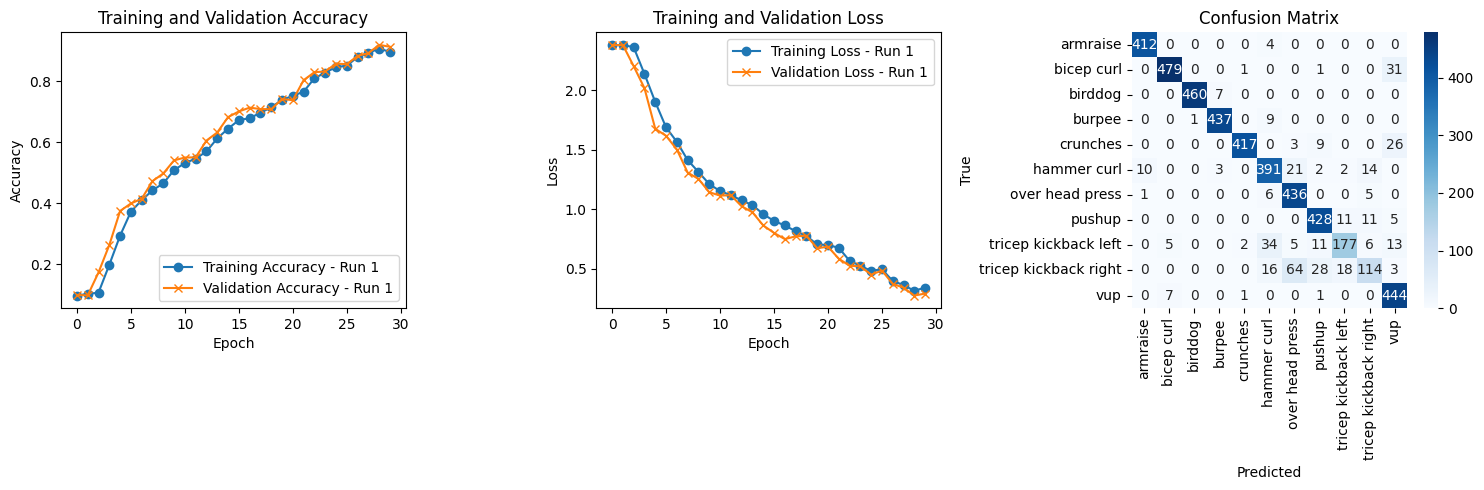

Epoch 1/30
287/287 [==============================] - 135s 466ms/step - loss: 2.3760 - accuracy: 0.0974 - val_loss: 2.3777 - val_accuracy: 0.0908
Epoch 2/30
287/287 [==============================] - 134s 467ms/step - loss: 2.3765 - accuracy: 0.1069 - val_loss: 2.1797 - val_accuracy: 0.1877
Epoch 3/30
287/287 [==============================] - 134s 467ms/step - loss: 2.0872 - accuracy: 0.2262 - val_loss: 1.8988 - val_accuracy: 0.2894
Epoch 4/30
287/287 [==============================] - 134s 467ms/step - loss: 1.7777 - accuracy: 0.3295 - val_loss: 1.5751 - val_accuracy: 0.3730
Epoch 5/30
287/287 [==============================] - 134s 468ms/step - loss: 1.4776 - accuracy: 0.4020 - val_loss: 1.2707 - val_accuracy: 0.4754
Epoch 6/30
287/287 [==============================] - 134s 467ms/step - loss: 1.2740 - accuracy: 0.4706 - val_loss: 1.2114 - val_accuracy: 0.4954
Epoch 7/30
287/287 [==============================] - 135s 471ms/step - loss: 1.1674 - accuracy: 0.5261 - val_loss: 1.1184 -

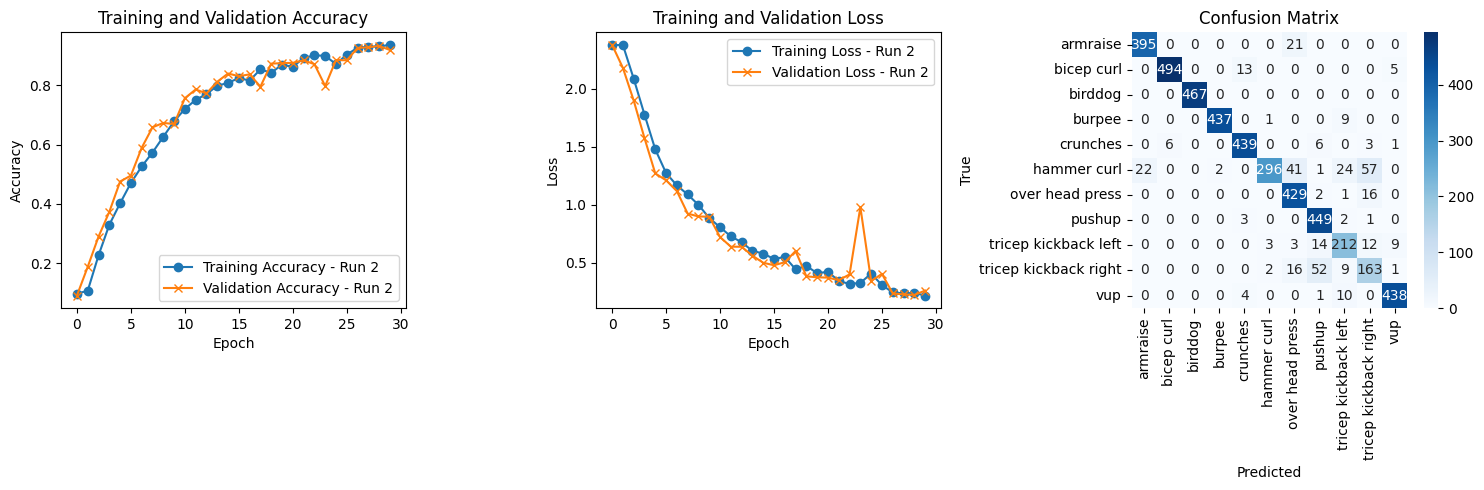

Epoch 1/30
287/287 [==============================] - 135s 466ms/step - loss: 2.3758 - accuracy: 0.1011 - val_loss: 2.3769 - val_accuracy: 0.1115
Epoch 2/30
287/287 [==============================] - 134s 466ms/step - loss: 2.3754 - accuracy: 0.0985 - val_loss: 2.3773 - val_accuracy: 0.0991
Epoch 3/30
287/287 [==============================] - 133s 465ms/step - loss: 2.3621 - accuracy: 0.1083 - val_loss: 2.2301 - val_accuracy: 0.1627
Epoch 4/30
287/287 [==============================] - 134s 469ms/step - loss: 2.1227 - accuracy: 0.2084 - val_loss: 2.0303 - val_accuracy: 0.2657
Epoch 5/30
287/287 [==============================] - 134s 467ms/step - loss: 1.9200 - accuracy: 0.2877 - val_loss: 1.7123 - val_accuracy: 0.3654
Epoch 6/30
287/287 [==============================] - 134s 466ms/step - loss: 1.6434 - accuracy: 0.3775 - val_loss: 1.5003 - val_accuracy: 0.4199
Epoch 7/30
287/287 [==============================] - 134s 467ms/step - loss: 1.4233 - accuracy: 0.4268 - val_loss: 1.2970 -

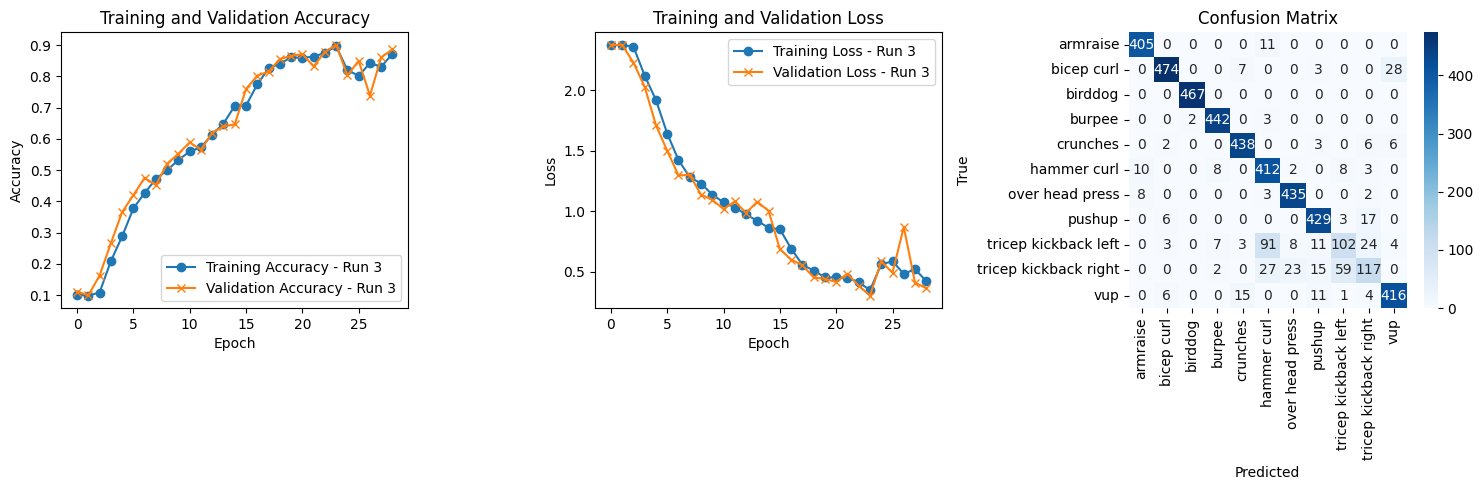

Epoch 1/30
287/287 [==============================] - 134s 460ms/step - loss: 2.3759 - accuracy: 0.0973 - val_loss: 2.3773 - val_accuracy: 0.0997
Epoch 2/30
287/287 [==============================] - 133s 462ms/step - loss: 2.2323 - accuracy: 0.1641 - val_loss: 2.1145 - val_accuracy: 0.1982
Epoch 3/30
287/287 [==============================] - 136s 474ms/step - loss: 2.1107 - accuracy: 0.2104 - val_loss: 2.0186 - val_accuracy: 0.2552
Epoch 4/30
287/287 [==============================] - 136s 474ms/step - loss: 2.0038 - accuracy: 0.2549 - val_loss: 1.8494 - val_accuracy: 0.3034
Epoch 5/30
287/287 [==============================] - 135s 471ms/step - loss: 1.7738 - accuracy: 0.3244 - val_loss: 1.6203 - val_accuracy: 0.3611
Epoch 6/30
287/287 [==============================] - 136s 474ms/step - loss: 1.4866 - accuracy: 0.3916 - val_loss: 1.3430 - val_accuracy: 0.4495
Epoch 7/30
287/287 [==============================] - 136s 475ms/step - loss: 1.3210 - accuracy: 0.4366 - val_loss: 1.2284 -

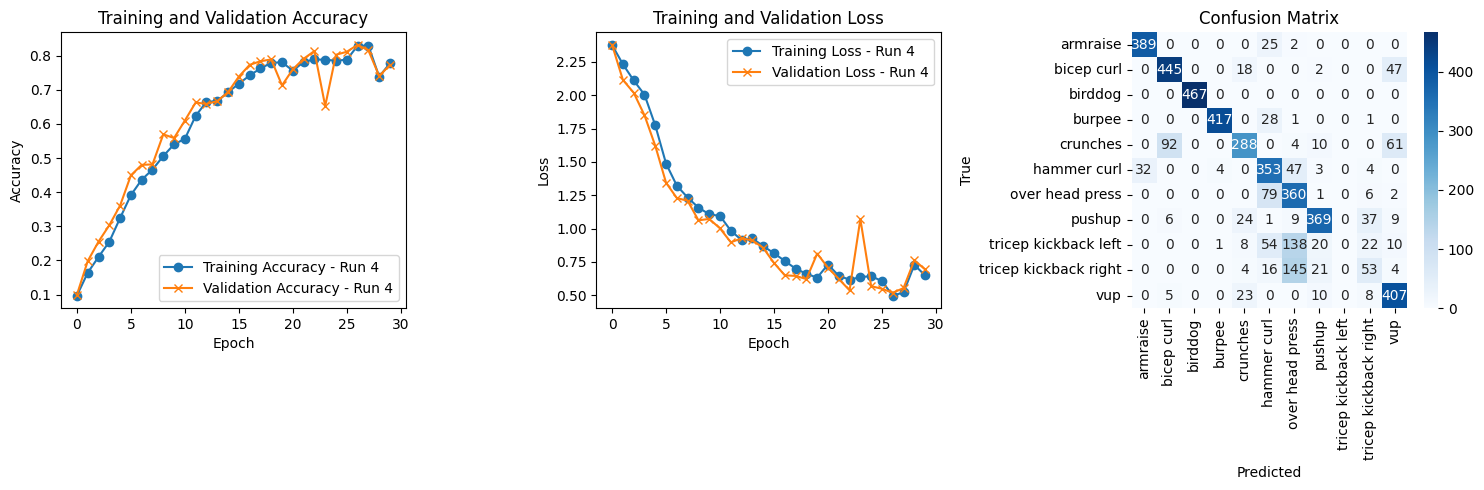

Epoch 1/30
287/287 [==============================] - 138s 475ms/step - loss: 2.3758 - accuracy: 0.1008 - val_loss: 2.3777 - val_accuracy: 0.0991
Epoch 2/30
287/287 [==============================] - 136s 473ms/step - loss: 2.3771 - accuracy: 0.0996 - val_loss: 2.5463 - val_accuracy: 0.1163
Epoch 3/30
287/287 [==============================] - 138s 482ms/step - loss: 2.3722 - accuracy: 0.0985 - val_loss: 2.3770 - val_accuracy: 0.0991
Epoch 4/30
287/287 [==============================] - 138s 480ms/step - loss: 2.3743 - accuracy: 0.1065 - val_loss: 2.2337 - val_accuracy: 0.1688
Epoch 5/30
287/287 [==============================] - 139s 483ms/step - loss: 2.1432 - accuracy: 0.1965 - val_loss: 2.0953 - val_accuracy: 0.2030
Epoch 6/30
287/287 [==============================] - 139s 486ms/step - loss: 2.0593 - accuracy: 0.2280 - val_loss: 1.9741 - val_accuracy: 0.2628
Epoch 7/30
287/287 [==============================] - 140s 488ms/step - loss: 1.8562 - accuracy: 0.3035 - val_loss: 1.6849 -

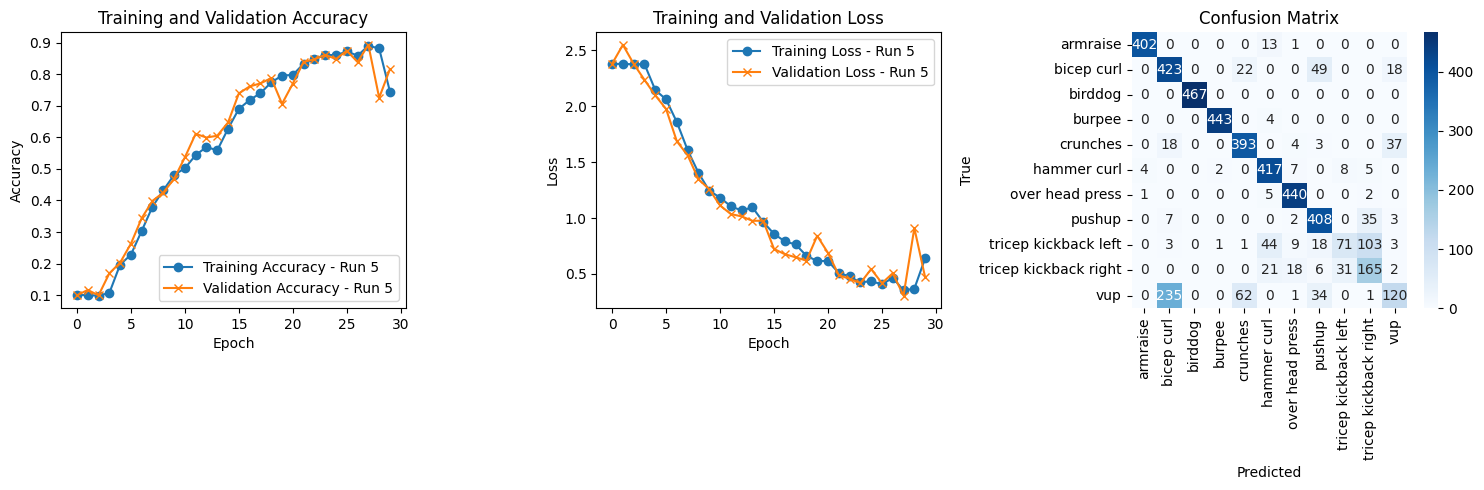

In [43]:
# Define the number of runs
num_runs = 5
all_history_1_Rep_3 = []

# Configure ModelCheckpoint callback to save weights
weights_dir = '../models/model1_3_weights'
os.makedirs(weights_dir, exist_ok=True)
checkpoint_filepath = os.path.join(weights_dir, 'weights_run_{epoch:02d}.h5')

# Train the model and store the history for each run
for run in range(num_runs):
    model1_3 = Sequential()
    model1_3.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
    model1_3.add(Dropout(0.3))  
    model1_3.add(Dense(64, activation='tanh'))  
    model1_3.add(Dropout(0.3))  
    model1_3.add(Dense(11, activation='softmax'))
    
    optimizer = Adam(learning_rate=0.001)
    model1_3.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # ModelCheckpoint callback with a dynamic file path
    model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath.replace('{run}', str(run)), save_weights_only=True, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model1_3.fit(X_train, y_train_one_hot, epochs=30, batch_size=64, validation_data=(X_test, y_test_one_hot), callbacks=[early_stopping])
    all_history_1_Rep_3.append(history)

    plt.figure(figsize=(15, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label=f'Training Accuracy - Run {run + 1}', marker='o')
    plt.plot(history.history['val_accuracy'], label=f'Validation Accuracy - Run {run + 1}', marker='x')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'], label=f'Training Loss - Run {run + 1}', marker='o')
    plt.plot(history.history['val_loss'], label=f'Validation Loss - Run {run + 1}', marker='x')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot confusion matrix
    plt.subplot(1, 3, 3)

    # Obtain predictions and calculate the confusion matrix
    y_pred = model1_3.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test_one_hot, axis=1)
    cm = confusion_matrix(y_true, y_pred_classes)

    class_labels = ['armraise', 'bicep curl', 'birddog', 'burpee', 'crunches', 'hammer curl', 'over head press', 'pushup', 'tricep kickback left', 'tricep kickback right', 'vup']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.tight_layout()
    plt.show()

# Save the final model weights
final_weights_filepath = os.path.join(weights_dir, 'final_weights.h5')
model1_3.save_weights(final_weights_filepath)

In [44]:
# Calculate the grand mean of each metric
grand_mean_accuracy = sum([run.history['accuracy'][-1] for run in all_history_1_Rep_3]) / num_runs
grand_mean_loss = sum([run.history['loss'][-1] for run in all_history_1_Rep_3]) / num_runs

print(f"Grand Mean Accuracy: {grand_mean_accuracy}")
print(f"Grand Mean Loss: {grand_mean_loss}")

Grand Mean Accuracy: 0.8455213665962219
Grand Mean Loss: 0.4537777602672577


There was a pretty good improvement in these runs in our numbers. Our Mean accuracy has increased from 65% to 84%, our highest accuracy seen was about 91%. There is a pretty even consistency through all the runs which is nice to see.

### One Rep, Attempt Four

For this model we have increased the number of LSTM units, adjusted the drop out numbers slightly and added additional epochs. For full disclosure I have tried many, many different adjustments with the numbers and layers that are not all included here. So the changes in the parameters are not completely arbitrary.

Epoch 1/40
287/287 [==============================] - 200s 691ms/step - loss: 2.3783 - accuracy: 0.1009 - val_loss: 2.3783 - val_accuracy: 0.0976
Epoch 2/40
287/287 [==============================] - 209s 727ms/step - loss: 2.3726 - accuracy: 0.1002 - val_loss: 2.3778 - val_accuracy: 0.0986
Epoch 3/40
287/287 [==============================] - 217s 757ms/step - loss: 2.3721 - accuracy: 0.1002 - val_loss: 2.3779 - val_accuracy: 0.0906
Epoch 4/40
287/287 [==============================] - 226s 786ms/step - loss: 2.3718 - accuracy: 0.1018 - val_loss: 2.3773 - val_accuracy: 0.0995
Epoch 5/40
287/287 [==============================] - 224s 781ms/step - loss: 2.3716 - accuracy: 0.1017 - val_loss: 2.3770 - val_accuracy: 0.0980
Epoch 6/40
287/287 [==============================] - 214s 747ms/step - loss: 2.3725 - accuracy: 0.1031 - val_loss: 3.3100 - val_accuracy: 0.1270
Epoch 7/40
287/287 [==============================] - 221s 772ms/step - loss: 2.3881 - accuracy: 0.0994 - val_loss: 2.3778 -

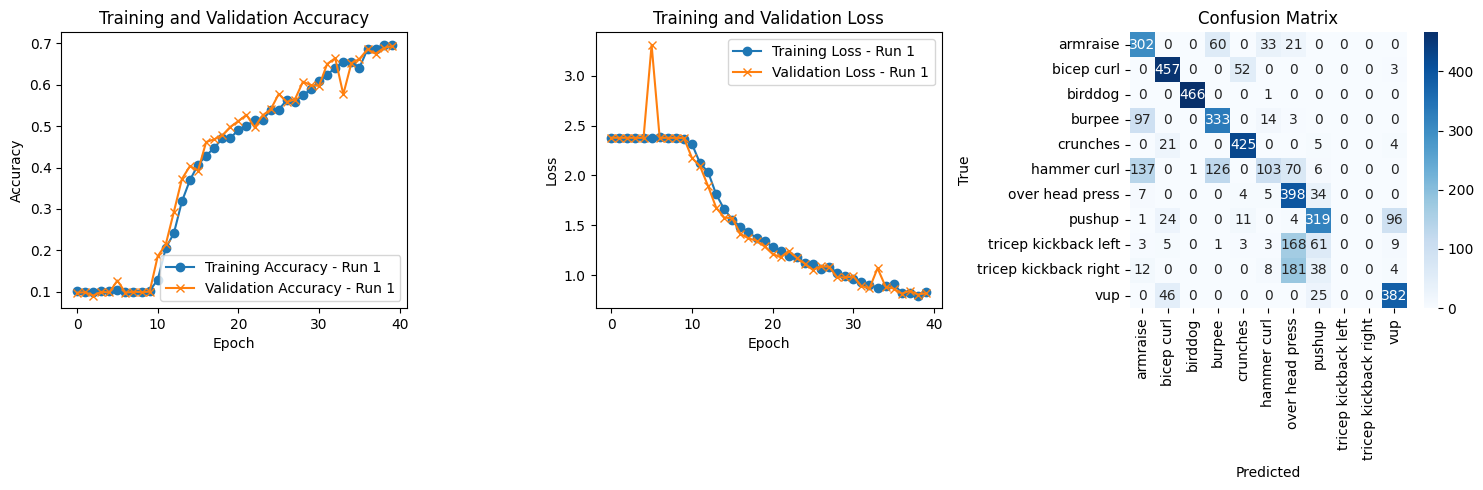

Epoch 1/40
287/287 [==============================] - 259s 889ms/step - loss: 2.3790 - accuracy: 0.1019 - val_loss: 2.3774 - val_accuracy: 0.0965
Epoch 2/40
287/287 [==============================] - 260s 904ms/step - loss: 2.3723 - accuracy: 0.1020 - val_loss: 2.3776 - val_accuracy: 0.0976
Epoch 3/40
287/287 [==============================] - 260s 905ms/step - loss: 2.3716 - accuracy: 0.1048 - val_loss: 2.3776 - val_accuracy: 0.0976
Epoch 4/40
287/287 [==============================] - 259s 903ms/step - loss: 2.3714 - accuracy: 0.1047 - val_loss: 2.3775 - val_accuracy: 0.0980
Epoch 5/40
287/287 [==============================] - 258s 900ms/step - loss: 2.3713 - accuracy: 0.1000 - val_loss: 2.3767 - val_accuracy: 0.0993
Epoch 6/40
287/287 [==============================] - 258s 899ms/step - loss: 2.2236 - accuracy: 0.1647 - val_loss: 2.1358 - val_accuracy: 0.1912
Epoch 7/40
287/287 [==============================] - 255s 888ms/step - loss: 2.1002 - accuracy: 0.2142 - val_loss: 2.0342 -

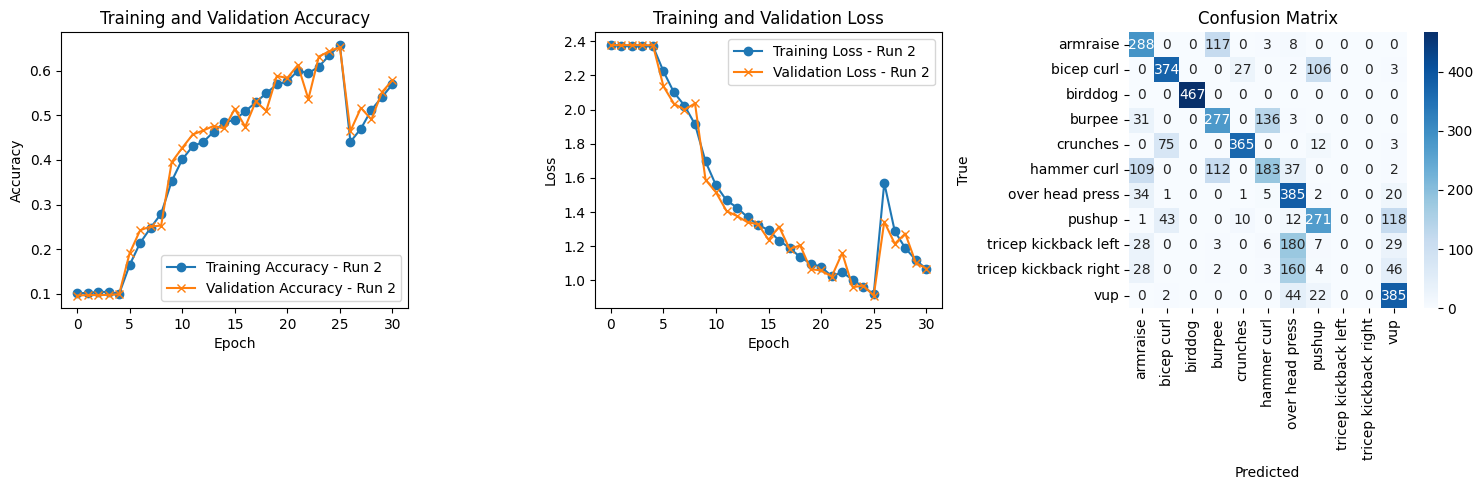

Epoch 1/40
287/287 [==============================] - 231s 800ms/step - loss: 2.3776 - accuracy: 0.1001 - val_loss: 2.3788 - val_accuracy: 0.0965
Epoch 2/40
287/287 [==============================] - 240s 837ms/step - loss: 2.3729 - accuracy: 0.0951 - val_loss: 2.3798 - val_accuracy: 0.0991
Epoch 3/40
287/287 [==============================] - 241s 841ms/step - loss: 2.3720 - accuracy: 0.0965 - val_loss: 2.3781 - val_accuracy: 0.0976
Epoch 4/40
287/287 [==============================] - 222s 773ms/step - loss: 2.3720 - accuracy: 0.0981 - val_loss: 2.3774 - val_accuracy: 0.0993
Epoch 5/40
287/287 [==============================] - 223s 779ms/step - loss: 2.3713 - accuracy: 0.0991 - val_loss: 2.3783 - val_accuracy: 0.0997
Epoch 6/40
287/287 [==============================] - 223s 777ms/step - loss: 2.3723 - accuracy: 0.1104 - val_loss: 2.3246 - val_accuracy: 0.1280
Epoch 7/40
287/287 [==============================] - 223s 778ms/step - loss: 2.1601 - accuracy: 0.1881 - val_loss: 2.0936 -

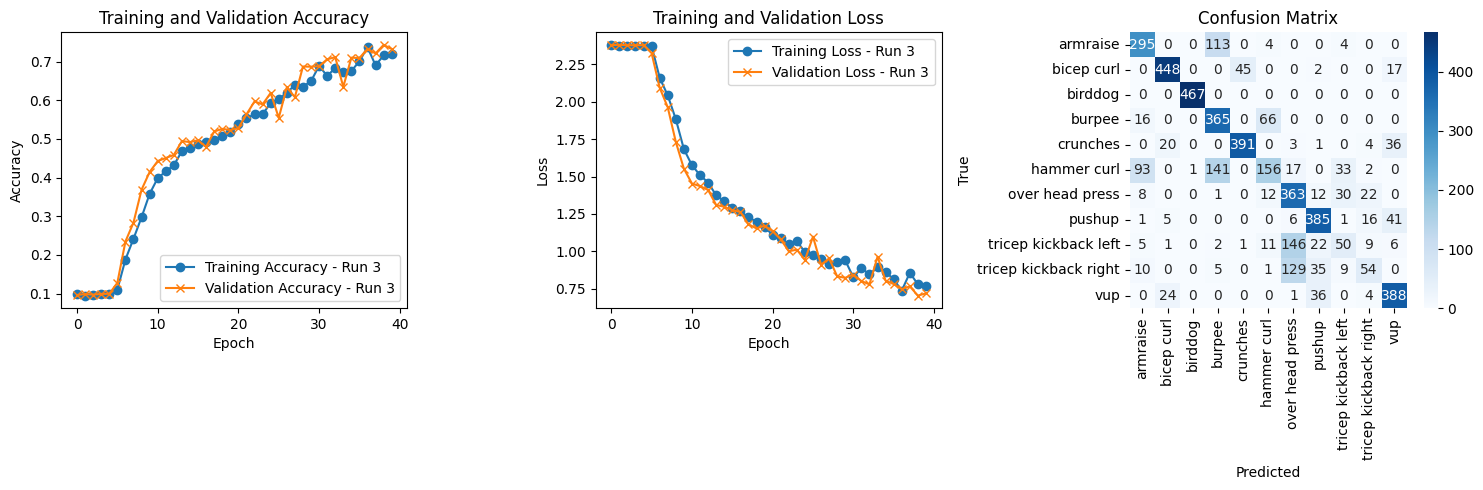

Epoch 1/40
287/287 [==============================] - 227s 787ms/step - loss: 2.3794 - accuracy: 0.0985 - val_loss: 2.3773 - val_accuracy: 0.0997
Epoch 2/40
287/287 [==============================] - 228s 794ms/step - loss: 2.3731 - accuracy: 0.1022 - val_loss: 2.3786 - val_accuracy: 0.0965
Epoch 3/40
287/287 [==============================] - 234s 817ms/step - loss: 2.3727 - accuracy: 0.1010 - val_loss: 2.3781 - val_accuracy: 0.0910
Epoch 4/40
287/287 [==============================] - 245s 854ms/step - loss: 2.3720 - accuracy: 0.1016 - val_loss: 2.3778 - val_accuracy: 0.0991
Epoch 5/40
287/287 [==============================] - 246s 859ms/step - loss: 2.3717 - accuracy: 0.1034 - val_loss: 2.3771 - val_accuracy: 0.0969
Epoch 6/40
287/287 [==============================] - 246s 857ms/step - loss: 2.3717 - accuracy: 0.0958 - val_loss: 2.3766 - val_accuracy: 0.0984
Epoch 7/40
287/287 [==============================] - 234s 816ms/step - loss: 2.3352 - accuracy: 0.1227 - val_loss: 2.2287 -

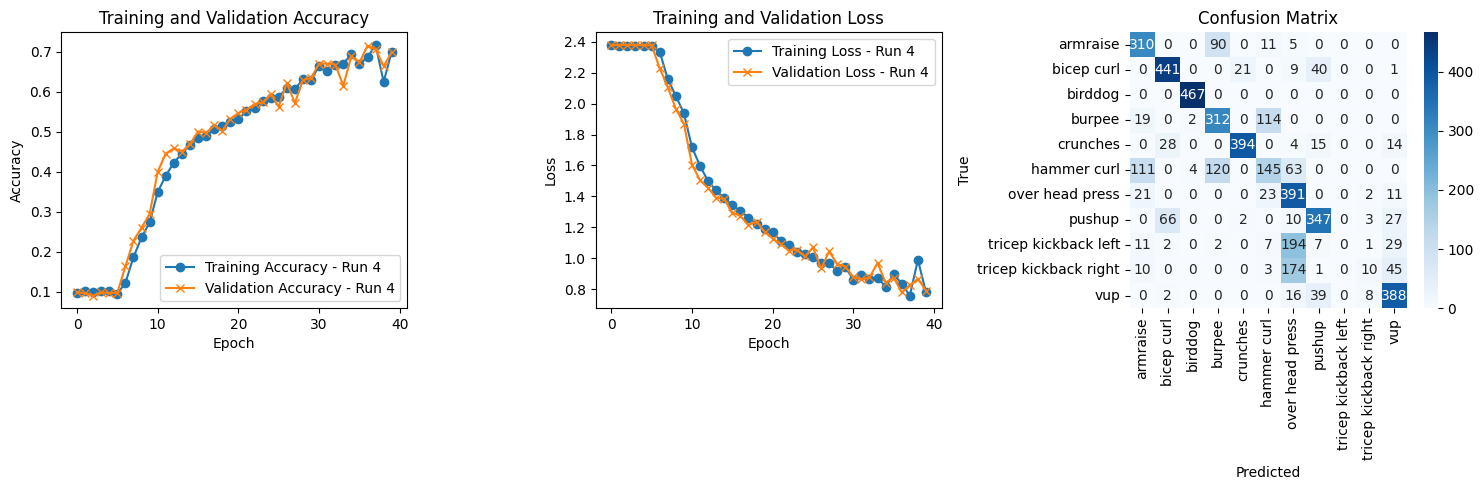

Epoch 1/40
287/287 [==============================] - 210s 725ms/step - loss: 2.3780 - accuracy: 0.0992 - val_loss: 2.3772 - val_accuracy: 0.1017
Epoch 2/40
287/287 [==============================] - 208s 726ms/step - loss: 2.3724 - accuracy: 0.1005 - val_loss: 2.3776 - val_accuracy: 0.0986
Epoch 3/40
287/287 [==============================] - 209s 730ms/step - loss: 2.3721 - accuracy: 0.0989 - val_loss: 2.3778 - val_accuracy: 0.0910
Epoch 4/40
287/287 [==============================] - 208s 727ms/step - loss: 2.3826 - accuracy: 0.1053 - val_loss: 2.3807 - val_accuracy: 0.0986
Epoch 5/40
287/287 [==============================] - 208s 725ms/step - loss: 2.3726 - accuracy: 0.0986 - val_loss: 2.3775 - val_accuracy: 0.0991
Epoch 6/40
144/144 [==============================] - 20s 134ms/step


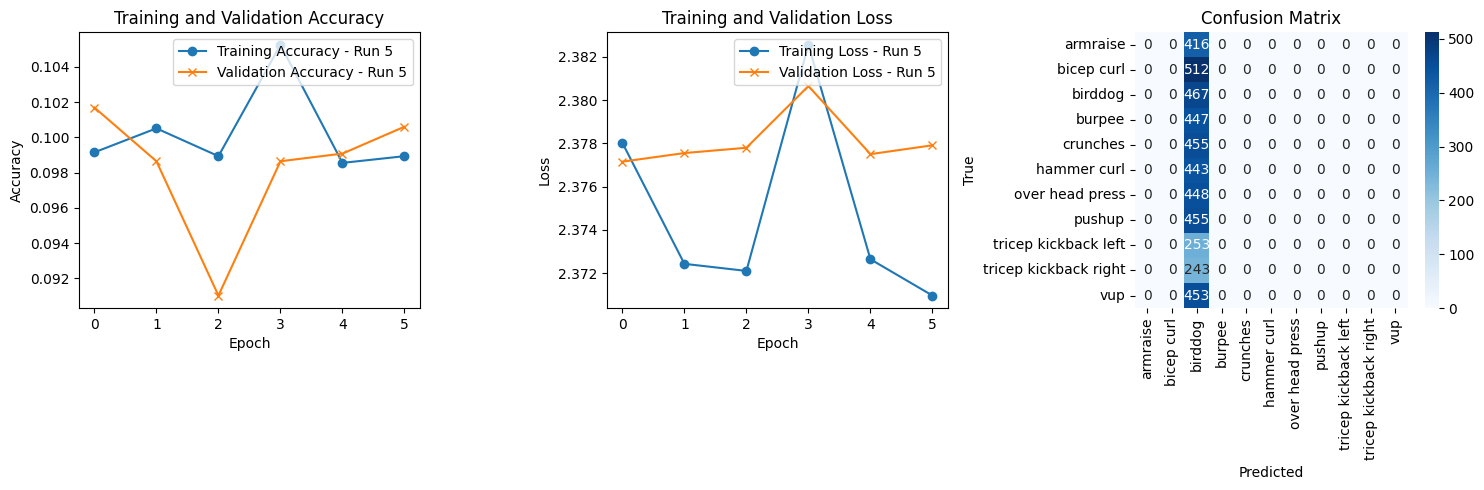

In [40]:

# Define the number of runs
num_runs = 5
all_history_1_Rep_4 = []

# Configure ModelCheckpoint callback to save weights
weights_dir = '../models/model1_4_weights'
os.makedirs(weights_dir, exist_ok=True)
checkpoint_filepath = os.path.join(weights_dir, 'weights_run_{epoch:02d}.h5')

# Train the model and store the history for each run
for run in range(num_runs):
    # Create and compile the model for each run
    model1_4 = Sequential()
    model1_4.add(LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2])))
    model1_4.add(Dropout(0.2))  
    model1_4.add(Dense(64, activation = 'tanh'))  
    model1_4.add(Dropout(0.2))  
    model1_4.add(Dense(11, activation='softmax'))
    
    optimizer = Adam(learning_rate=0.0001)
    model1_4.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # ModelCheckpoint callback with a dynamic file path
    model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath.replace('{run}', str(run)), save_weights_only=True, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model1_4.fit(X_train, y_train_one_hot, epochs=40, batch_size=64, validation_data=(X_test, y_test_one_hot), callbacks=[early_stopping])
    all_history_1_Rep_4.append(history)

    plt.figure(figsize=(15, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label=f'Training Accuracy - Run {run + 1}', marker='o')
    plt.plot(history.history['val_accuracy'], label=f'Validation Accuracy - Run {run + 1}', marker='x')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'], label=f'Training Loss - Run {run + 1}', marker='o')
    plt.plot(history.history['val_loss'], label=f'Validation Loss - Run {run + 1}', marker='x')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot confusion matrix
    plt.subplot(1, 3, 3)

    # Obtain predictions and calculate the confusion matrix
    y_pred = model1_4.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test_one_hot, axis=1)
    cm = confusion_matrix(y_true, y_pred_classes)

    class_labels = ['armraise', 'bicep curl', 'birddog', 'burpee', 'crunches', 'hammer curl', 'over head press', 'pushup', 'tricep kickback left', 'tricep kickback right', 'vup']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.tight_layout()
    plt.show()

# Save the final model weights
final_weights_filepath = os.path.join(weights_dir, 'final_weights.h5')
model1_4.save_weights(final_weights_filepath)

In [41]:
# Calculate the grand mean of each metric
grand_mean_accuracy = sum([run.history['accuracy'][-1] for run in all_history_1_Rep_4]) / num_runs
grand_mean_loss = sum([run.history['loss'][-1] for run in all_history_1_Rep_4]) / num_runs

print(f"Grand Mean Accuracy: {grand_mean_accuracy}")
print(f"Grand Mean Loss: {grand_mean_loss}")

Grand Mean Accuracy: 0.5567002475261689
Grand Mean Loss: 1.1633333683013916


Average is down from our last model and our highest accuracy is 73%. Lets try a different route.

### Hyper Parameter Tuning with Keras Tuner

Even though I got some pretty okay results above with a lot of trial and error, I was curious to see how the keras_tuner did on the hyperparameter tuning.

In [34]:
# model function for our tuner, takes hyperparameters as an argument

def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=256, step=32), input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('dense_units', min_value=32, max_value=128, step=32), kernel_regularizer=l2(hp.Float('l2_regularizer', min_value=1e-5, max_value=1e-1, sampling='log'))))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(11, activation='softmax'))

    optimizer = Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model


In [35]:
# setting up Keras tuner Hyperband tuner to find paramters that will result in the lowest validation loss
tuner = kt.Hyperband(build_model,
                     objective='val_loss',
                     max_epochs=30,
                     factor=3,
                     directory='../models/my_tuning_dir',
                     project_name='my_lstm_tuning')

Reloading Tuner from ../models/my_tuning_dir\my_lstm_tuning\tuner0.json


In [ ]:
#hyperparameter tuner search, full run of this estimated to be 4+ days. I will revisit this later when I have more time.

tuner.search(X_train, y_train_one_hot, epochs=30, validation_data=(X_test, y_test_one_hot))

I did stop the tuning prematurely when I saw the estimated time as 4 days. I will let it run once everything required for this course is finished, but I don't have the time to let it run that long at this moment. We did get 89 trials complete so we are going to run some models with the best results from those 89 trials.

In [36]:
# Retrieve hyperparameters of the best-performing model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Display the best hyperparameters
print("Best Hyperparameters:")
print(f"Units: {best_hps.get('units')}")
print(f"Dropout: {best_hps.get('dropout')}")
print(f"Dense Units: {best_hps.get('dense_units')}")
print(f"L2 Regularizer: {best_hps.get('l2_regularizer')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")

# Build the best model using the retrieved hyperparameters
best_model = tuner.hypermodel.build(best_hps)


Best Hyperparameters:
Units: 256
Dropout: 0.2
Dense Units: 96
L2 Regularizer: 8.499376204663732e-05
Learning Rate: 0.0013475237088255072


In [42]:
# Summary of the 10 best models
tuner.results_summary()

Results summary
Results in ../models/my_tuning_dir\my_lstm_tuning
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0083 summary
Hyperparameters:
units: 256
dropout: 0.2
dense_units: 96
l2_regularizer: 8.499376204663732e-05
learning_rate: 0.0013475237088255072
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0077
Score: 0.10438397526741028

Trial 0072 summary
Hyperparameters:
units: 160
dropout: 0.2
dense_units: 32
l2_regularizer: 9.044717534680572e-05
learning_rate: 0.00491459224483046
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0067
Score: 0.1898944228887558

Trial 0084 summary
Hyperparameters:
units: 160
dropout: 0.30000000000000004
dense_units: 128
l2_regularizer: 3.1394645819639884e-05
learning_rate: 0.004215595254424248
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0078
Score: 0.1985154151916504

Trial 0087 summary
Hyperparameters

Epoch 1/30
574/574 [==============================] - 178s 307ms/step - loss: 2.4729 - accuracy: 0.0982 - val_loss: 2.4628 - val_accuracy: 0.1032
Epoch 2/30
574/574 [==============================] - 178s 310ms/step - loss: 2.3958 - accuracy: 0.1267 - val_loss: 2.2868 - val_accuracy: 0.1537
Epoch 3/30
574/574 [==============================] - 179s 312ms/step - loss: 2.1119 - accuracy: 0.2217 - val_loss: 1.6890 - val_accuracy: 0.3036
Epoch 4/30
574/574 [==============================] - 179s 313ms/step - loss: 1.4852 - accuracy: 0.4029 - val_loss: 1.2923 - val_accuracy: 0.4865
Epoch 5/30
574/574 [==============================] - 181s 315ms/step - loss: 1.1147 - accuracy: 0.5753 - val_loss: 1.0587 - val_accuracy: 0.6302
Epoch 6/30
574/574 [==============================] - 182s 317ms/step - loss: 0.7451 - accuracy: 0.7393 - val_loss: 0.6873 - val_accuracy: 0.7668
Epoch 7/30
574/574 [==============================] - 180s 314ms/step - loss: 0.5498 - accuracy: 0.8204 - val_loss: 0.5206 -

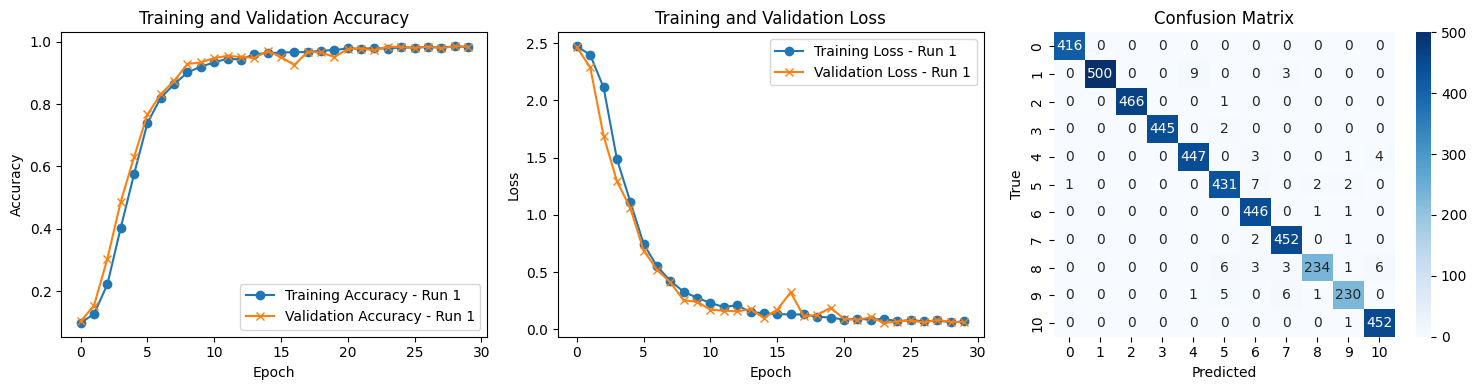

Epoch 1/30
574/574 [==============================] - 189s 326ms/step - loss: 2.4048 - accuracy: 0.1486 - val_loss: 2.3878 - val_accuracy: 0.1254
Epoch 2/30
574/574 [==============================] - 214s 374ms/step - loss: 2.2077 - accuracy: 0.2045 - val_loss: 2.0947 - val_accuracy: 0.2291
Epoch 3/30
574/574 [==============================] - 242s 421ms/step - loss: 1.9548 - accuracy: 0.2741 - val_loss: 1.6111 - val_accuracy: 0.3715
Epoch 4/30
574/574 [==============================] - 240s 418ms/step - loss: 1.4700 - accuracy: 0.4134 - val_loss: 1.4200 - val_accuracy: 0.4395
Epoch 5/30
574/574 [==============================] - 240s 418ms/step - loss: 1.2703 - accuracy: 0.5105 - val_loss: 1.6821 - val_accuracy: 0.4009
Epoch 6/30
574/574 [==============================] - 241s 419ms/step - loss: 0.9934 - accuracy: 0.6443 - val_loss: 0.9121 - val_accuracy: 0.6790
Epoch 7/30
574/574 [==============================] - 244s 425ms/step - loss: 0.8054 - accuracy: 0.7161 - val_loss: 0.9240 -

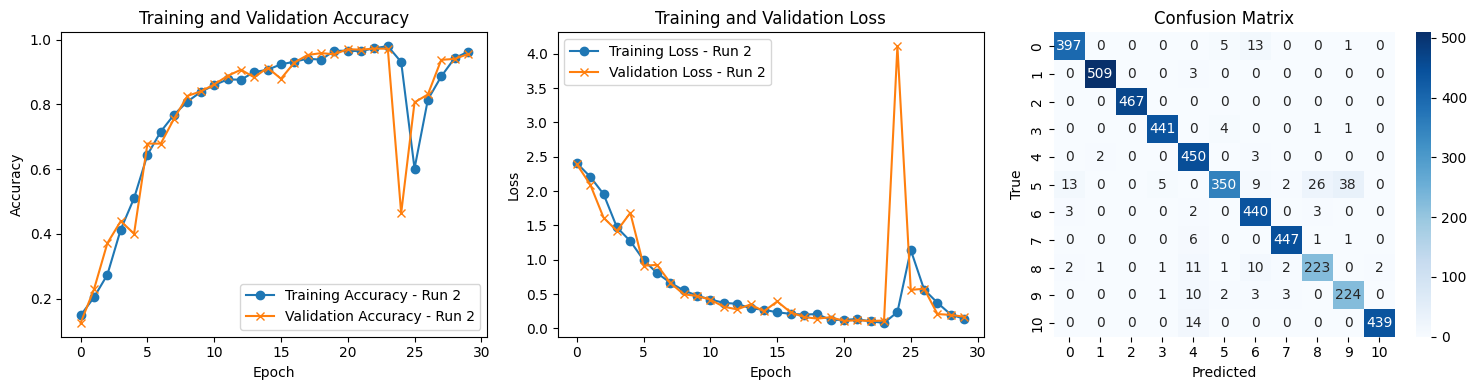

Epoch 1/30
574/574 [==============================] - 267s 462ms/step - loss: 2.4066 - accuracy: 0.0971 - val_loss: 2.4031 - val_accuracy: 0.0995
Epoch 2/30
574/574 [==============================] - 262s 456ms/step - loss: 2.4132 - accuracy: 0.1078 - val_loss: 2.5280 - val_accuracy: 0.1254
Epoch 3/30
574/574 [==============================] - 261s 455ms/step - loss: 2.2718 - accuracy: 0.1735 - val_loss: 2.3785 - val_accuracy: 0.1659
Epoch 4/30
574/574 [==============================] - 259s 452ms/step - loss: 2.1814 - accuracy: 0.2039 - val_loss: 2.0387 - val_accuracy: 0.2685
Epoch 5/30
574/574 [==============================] - 261s 454ms/step - loss: 1.8373 - accuracy: 0.3089 - val_loss: 1.5275 - val_accuracy: 0.4179
Epoch 6/30
574/574 [==============================] - 259s 452ms/step - loss: 1.3914 - accuracy: 0.4136 - val_loss: 1.3236 - val_accuracy: 0.4292
Epoch 7/30
574/574 [==============================] - 256s 446ms/step - loss: 1.5402 - accuracy: 0.4097 - val_loss: 2.0799 -

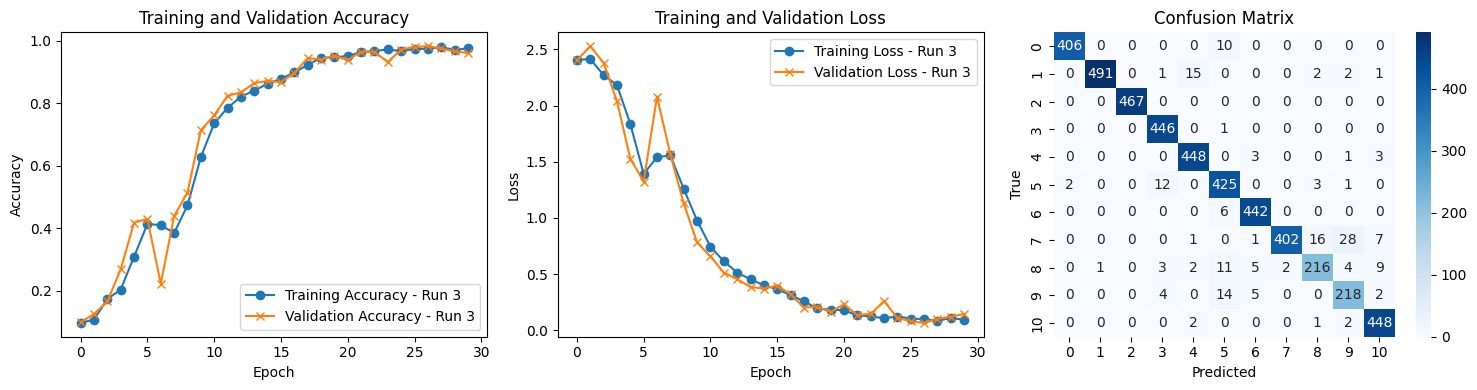

Epoch 1/30
574/574 [==============================] - 262s 453ms/step - loss: 2.4054 - accuracy: 0.1039 - val_loss: 2.3965 - val_accuracy: 0.0995
Epoch 2/30
574/574 [==============================] - 261s 455ms/step - loss: 2.3910 - accuracy: 0.1065 - val_loss: 2.4300 - val_accuracy: 0.1143
Epoch 3/30
574/574 [==============================] - 262s 456ms/step - loss: 2.2735 - accuracy: 0.1683 - val_loss: 2.1387 - val_accuracy: 0.1956
Epoch 4/30
574/574 [==============================] - 263s 459ms/step - loss: 1.7843 - accuracy: 0.3281 - val_loss: 1.4784 - val_accuracy: 0.3639
Epoch 5/30
574/574 [==============================] - 263s 458ms/step - loss: 1.2773 - accuracy: 0.4897 - val_loss: 1.1907 - val_accuracy: 0.5577
Epoch 6/30
574/574 [==============================] - 260s 454ms/step - loss: 0.8536 - accuracy: 0.6865 - val_loss: 0.6800 - val_accuracy: 0.7489
Epoch 7/30
574/574 [==============================] - 261s 455ms/step - loss: 0.6550 - accuracy: 0.7664 - val_loss: 0.5251 -

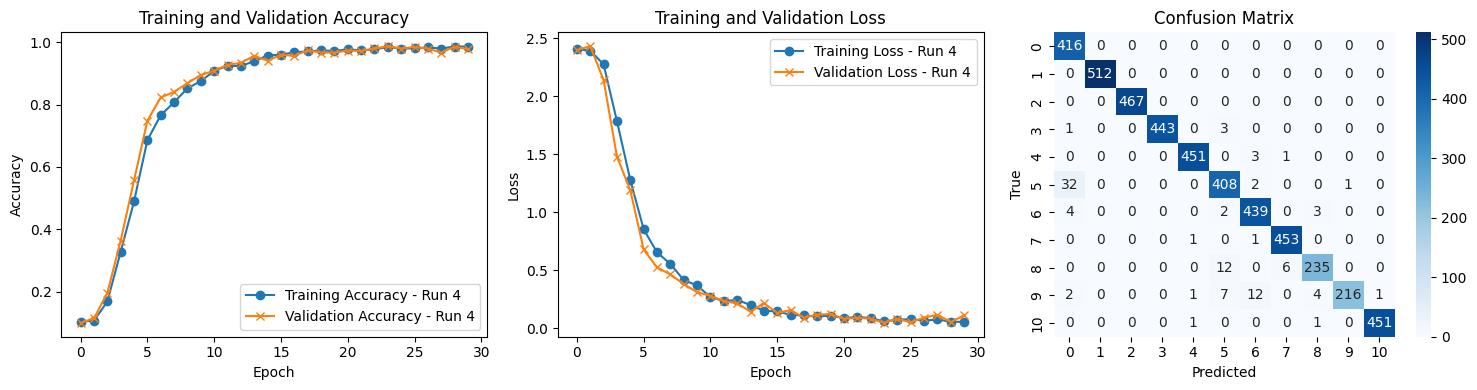

Epoch 1/30
574/574 [==============================] - 264s 458ms/step - loss: 2.4842 - accuracy: 0.1233 - val_loss: 2.1913 - val_accuracy: 0.1816
Epoch 2/30
574/574 [==============================] - 259s 452ms/step - loss: 2.2543 - accuracy: 0.1785 - val_loss: 2.2694 - val_accuracy: 0.1762
Epoch 3/30
574/574 [==============================] - 262s 457ms/step - loss: 2.1105 - accuracy: 0.2281 - val_loss: 2.0678 - val_accuracy: 0.2308
Epoch 4/30
574/574 [==============================] - 262s 456ms/step - loss: 1.6665 - accuracy: 0.3451 - val_loss: 1.6118 - val_accuracy: 0.3469
Epoch 5/30
574/574 [==============================] - 261s 456ms/step - loss: 1.3886 - accuracy: 0.4335 - val_loss: 1.5905 - val_accuracy: 0.3709
Epoch 6/30
574/574 [==============================] - 261s 456ms/step - loss: 1.1770 - accuracy: 0.5368 - val_loss: 0.9278 - val_accuracy: 0.6834
Epoch 7/30
574/574 [==============================] - 265s 461ms/step - loss: 0.9219 - accuracy: 0.6730 - val_loss: 0.8351 -

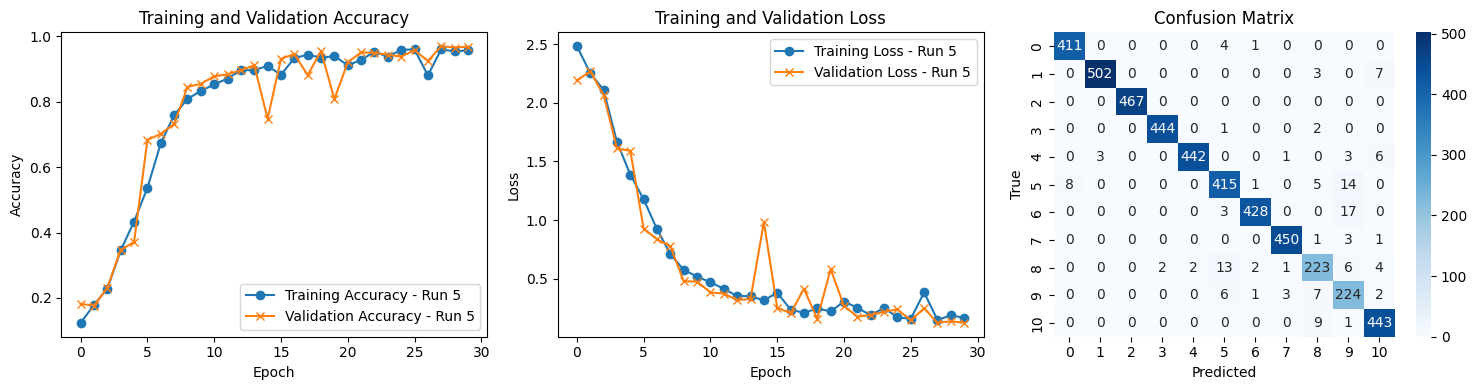

In [38]:
# Running best model 5 times

num_runs = 5
all_history_best_model = []

# Configure ModelCheckpoint callback to save weights
weights_dir = '../models/model_best_model_weights'
os.makedirs(weights_dir, exist_ok=True)
checkpoint_filepath = os.path.join(weights_dir, 'weights_run_{epoch:02d}.h5')

for run in range(num_runs):
    best_model = tuner.hypermodel.build(best_hps)
    
    model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath.replace('{run}', str(run)), save_weights_only=True, save_best_only=True)
       
    history = best_model.fit(X_train, y_train_one_hot, epochs=30, validation_data=(X_test, y_test_one_hot))
    test_loss, test_accuracy = best_model.evaluate(X_test, y_test_one_hot)
    all_history_best_model.append(history)
    print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

    plt.figure(figsize=(15, 4))

    # Plot training and validation accuracy
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label=f'Training Accuracy - Run {run + 1}', marker='o')
    plt.plot(history.history['val_accuracy'], label=f'Validation Accuracy - Run {run + 1}', marker='x')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'], label=f'Training Loss - Run {run + 1}', marker='o')
    plt.plot(history.history['val_loss'], label=f'Validation Loss - Run {run + 1}', marker='x')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot confusion matrix
    plt.subplot(1, 3, 3)

    # Obtain predictions and calculate the confusion matrix
    y_pred = best_model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test_one_hot, axis=1)
    cm = confusion_matrix(y_true, y_pred_classes)

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(11), yticklabels=range(11))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.tight_layout()
    plt.show()

# Save the final model weights
final_weights_filepath = os.path.join(weights_dir, 'final_weights.h5')
best_model.save_weights(final_weights_filepath)


In [39]:
# Calculate the grand mean of each metric
grand_mean_accuracy = sum([run.history['accuracy'][-1] for run in all_history_best_model]) / num_runs
grand_mean_loss = sum([run.history['loss'][-1] for run in all_history_best_model]) / num_runs

print(f"Grand Mean Accuracy: {grand_mean_accuracy}")
print(f"Grand Mean Loss: {grand_mean_loss}")

Grand Mean Accuracy: 0.9730138897895813
Grand Mean Loss: 0.10495533049106598


Wow these runs looks pretty good! 98% accuracy on that first one and an average of 97%. I will definitely want to finish running the tuner and look into this further when I have more time.